# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.6211023161986997 -3.109387043490154
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [109]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [110]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [111]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [112]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [113]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [135]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [136]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [138]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs) # GAN using success rate
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:]) # Q-learning using max future rewards
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)# Policy gradient for state and action mapping
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [139]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [140]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [141]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [142]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [143]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [144]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [162]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model2.ckpt')

Episode:0 meanR:51.0000 rate:0.1020 gloss:0.0884 dloss:1.3965 dlossR:0.7040 dlossQ:0.6925
Episode:1 meanR:63.0000 rate:0.1500 gloss:0.1031 dloss:1.3871 dlossR:0.6939 dlossQ:0.6931
Episode:2 meanR:83.6667 rate:0.2500 gloss:0.1816 dloss:1.3901 dlossR:0.6981 dlossQ:0.6920
Episode:3 meanR:75.5000 rate:0.1020 gloss:0.0330 dloss:1.3669 dlossR:0.6727 dlossQ:0.6942
Episode:4 meanR:68.2000 rate:0.0780 gloss:-0.0024 dloss:1.3533 dlossR:0.6594 dlossQ:0.6939
Episode:5 meanR:66.6667 rate:0.1180 gloss:0.0180 dloss:1.3543 dlossR:0.6596 dlossQ:0.6947
Episode:6 meanR:66.4286 rate:0.1300 gloss:0.0115 dloss:1.3483 dlossR:0.6531 dlossQ:0.6952
Episode:7 meanR:64.1250 rate:0.0960 gloss:-0.0348 dloss:1.3289 dlossR:0.6350 dlossQ:0.6939
Episode:8 meanR:64.4444 rate:0.1340 gloss:-0.0116 dloss:1.3354 dlossR:0.6402 dlossQ:0.6952
Episode:9 meanR:62.2000 rate:0.0840 gloss:-0.0706 dloss:1.3087 dlossR:0.6163 dlossQ:0.6924
Episode:10 meanR:64.8182 rate:0.1820 gloss:-0.0003 dloss:1.3363 dlossR:0.6390 dlossQ:0.6973
Epis

Episode:93 meanR:36.8298 rate:0.2100 gloss:-1.6705 dloss:0.9116 dlossR:0.6276 dlossQ:0.2840
Episode:94 meanR:36.9789 rate:0.1020 gloss:-1.7198 dloss:0.6100 dlossR:0.3392 dlossQ:0.2708
Episode:95 meanR:37.1562 rate:0.1080 gloss:-1.7028 dloss:0.6291 dlossR:0.3543 dlossQ:0.2748
Episode:96 meanR:37.2680 rate:0.0960 gloss:-1.6755 dloss:0.6035 dlossR:0.3216 dlossQ:0.2819
Episode:97 meanR:37.5306 rate:0.1260 gloss:-1.6275 dloss:0.6896 dlossR:0.3956 dlossQ:0.2940
Episode:98 meanR:37.5152 rate:0.0720 gloss:-1.6741 dloss:0.5437 dlossR:0.2604 dlossQ:0.2834
Episode:99 meanR:37.4300 rate:0.0580 gloss:-1.6541 dloss:0.5135 dlossR:0.2254 dlossQ:0.2882
Episode:100 meanR:37.2900 rate:0.0740 gloss:-1.5857 dloss:0.5709 dlossR:0.2648 dlossQ:0.3061
Episode:101 meanR:37.0300 rate:0.0980 gloss:-1.5832 dloss:0.6291 dlossR:0.3229 dlossQ:0.3062
Episode:102 meanR:36.0900 rate:0.0620 gloss:-1.6420 dloss:0.5280 dlossR:0.2358 dlossQ:0.2922
Episode:103 meanR:35.9800 rate:0.0800 gloss:-1.6370 dloss:0.5743 dlossR:0.280

Episode:187 meanR:36.6900 rate:0.1040 gloss:-1.5078 dloss:0.6686 dlossR:0.3370 dlossQ:0.3316
Episode:188 meanR:37.5800 rate:0.2000 gloss:-1.6686 dloss:0.9001 dlossR:0.6047 dlossQ:0.2954
Episode:189 meanR:37.8200 rate:0.0700 gloss:-1.3952 dloss:0.6259 dlossR:0.2627 dlossQ:0.3632
Episode:190 meanR:38.2000 rate:0.1220 gloss:-1.4448 dloss:0.7256 dlossR:0.3760 dlossQ:0.3495
Episode:191 meanR:38.0300 rate:0.0480 gloss:-1.4543 dloss:0.5608 dlossR:0.2142 dlossQ:0.3466
Episode:192 meanR:37.8200 rate:0.0920 gloss:-1.4756 dloss:0.6499 dlossR:0.3093 dlossQ:0.3406
Episode:193 meanR:38.4600 rate:0.3380 gloss:-1.2012 dloss:1.2558 dlossR:0.8248 dlossQ:0.4310
Episode:194 meanR:38.3700 rate:0.0840 gloss:-1.3368 dloss:0.6755 dlossR:0.2942 dlossQ:0.3814
Episode:195 meanR:38.2600 rate:0.0860 gloss:-1.3098 dloss:0.6889 dlossR:0.2993 dlossQ:0.3897
Episode:196 meanR:38.1600 rate:0.0760 gloss:-1.3843 dloss:0.6436 dlossR:0.2763 dlossQ:0.3674
Episode:197 meanR:37.8600 rate:0.0660 gloss:-1.4233 dloss:0.6103 dloss

Episode:279 meanR:72.5400 rate:0.1200 gloss:-0.5006 dloss:1.0917 dlossR:0.4588 dlossQ:0.6330
Episode:280 meanR:72.7300 rate:0.0620 gloss:-0.5522 dloss:1.0265 dlossR:0.4068 dlossQ:0.6197
Episode:281 meanR:72.8500 rate:0.0480 gloss:-0.5677 dloss:1.0085 dlossR:0.3929 dlossQ:0.6156
Episode:282 meanR:72.9700 rate:0.0460 gloss:-0.5816 dloss:1.0004 dlossR:0.3875 dlossQ:0.6130
Episode:283 meanR:73.1000 rate:0.0460 gloss:-0.5984 dloss:0.9906 dlossR:0.3818 dlossQ:0.6088
Episode:284 meanR:73.2300 rate:0.0540 gloss:-0.5797 dloss:1.0071 dlossR:0.3936 dlossQ:0.6135
Episode:285 meanR:73.1900 rate:0.0480 gloss:-0.6145 dloss:0.9830 dlossR:0.3782 dlossQ:0.6049
Episode:286 meanR:73.0400 rate:0.0380 gloss:-0.6453 dloss:0.9589 dlossR:0.3620 dlossQ:0.5969
Episode:287 meanR:72.7200 rate:0.0400 gloss:-0.6979 dloss:0.9299 dlossR:0.3481 dlossQ:0.5818
Episode:288 meanR:71.9400 rate:0.0440 gloss:-0.6883 dloss:0.9393 dlossR:0.3546 dlossQ:0.5847
Episode:289 meanR:71.9000 rate:0.0620 gloss:-0.6627 dloss:0.9692 dloss

Episode:371 meanR:77.0700 rate:0.0320 gloss:-1.0627 dloss:0.7211 dlossR:0.2458 dlossQ:0.4752
Episode:372 meanR:73.8700 rate:0.0420 gloss:-1.0745 dloss:0.7307 dlossR:0.2580 dlossQ:0.4727
Episode:373 meanR:72.7400 rate:0.0320 gloss:-1.1452 dloss:0.6798 dlossR:0.2307 dlossQ:0.4491
Episode:374 meanR:72.3600 rate:0.0260 gloss:-1.3683 dloss:0.5746 dlossR:0.1940 dlossQ:0.3806
Episode:375 meanR:71.3500 rate:0.0180 gloss:-1.7189 dloss:0.4517 dlossR:0.1584 dlossQ:0.2933
Episode:376 meanR:70.9600 rate:0.0460 gloss:-1.2171 dloss:0.6793 dlossR:0.2524 dlossQ:0.4269
Episode:377 meanR:70.3300 rate:0.0360 gloss:-1.2336 dloss:0.6551 dlossR:0.2306 dlossQ:0.4245
Episode:378 meanR:70.0300 rate:0.0840 gloss:-0.9602 dloss:0.8422 dlossR:0.3367 dlossQ:0.5056
Episode:379 meanR:70.0800 rate:0.1300 gloss:-0.9195 dloss:0.9241 dlossR:0.4066 dlossQ:0.5175
Episode:380 meanR:71.1900 rate:0.2840 gloss:-0.8141 dloss:1.1826 dlossR:0.6274 dlossQ:0.5552
Episode:381 meanR:71.8700 rate:0.1840 gloss:-0.8443 dloss:1.0254 dloss

Episode:463 meanR:138.4200 rate:0.0840 gloss:-0.2195 dloss:1.2297 dlossR:0.5541 dlossQ:0.6756
Episode:464 meanR:140.4000 rate:0.4680 gloss:0.3535 dloss:1.3830 dlossR:0.6961 dlossQ:0.6869
Episode:465 meanR:140.5200 rate:0.1280 gloss:-0.2159 dloss:1.2374 dlossR:0.5624 dlossQ:0.6750
Episode:466 meanR:140.6300 rate:0.1020 gloss:-0.2790 dloss:1.2000 dlossR:0.5340 dlossQ:0.6660
Episode:467 meanR:140.8500 rate:0.0920 gloss:-0.2962 dloss:1.1879 dlossR:0.5222 dlossQ:0.6657
Episode:468 meanR:141.1300 rate:0.1120 gloss:-0.2682 dloss:1.2082 dlossR:0.5407 dlossQ:0.6675
Episode:469 meanR:141.5400 rate:0.1260 gloss:-0.2914 dloss:1.2005 dlossR:0.5366 dlossQ:0.6639
Episode:470 meanR:142.1500 rate:0.1640 gloss:-0.2240 dloss:1.2433 dlossR:0.5705 dlossQ:0.6728
Episode:471 meanR:143.6100 rate:0.3240 gloss:0.2142 dloss:1.3854 dlossR:0.6920 dlossQ:0.6934
Episode:472 meanR:146.1000 rate:0.5400 gloss:0.3338 dloss:1.3966 dlossR:0.6971 dlossQ:0.6995
Episode:473 meanR:148.6700 rate:0.5460 gloss:0.3188 dloss:1.402

Episode:553 meanR:160.7700 rate:0.2500 gloss:-0.3542 dloss:1.2437 dlossR:0.5859 dlossQ:0.6578
Episode:554 meanR:160.8600 rate:0.1680 gloss:0.0844 dloss:1.3731 dlossR:0.6789 dlossQ:0.6943
Episode:555 meanR:161.2400 rate:0.2320 gloss:0.1278 dloss:1.3771 dlossR:0.6817 dlossQ:0.6953
Episode:556 meanR:161.6600 rate:0.2120 gloss:-0.4180 dloss:1.1973 dlossR:0.5554 dlossQ:0.6419
Episode:557 meanR:162.0900 rate:0.2240 gloss:-0.3940 dloss:1.2127 dlossR:0.5650 dlossQ:0.6476
Episode:558 meanR:162.7600 rate:0.2980 gloss:-0.3036 dloss:1.2933 dlossR:0.6278 dlossQ:0.6655
Episode:559 meanR:163.2800 rate:0.2020 gloss:-0.4214 dloss:1.1869 dlossR:0.5426 dlossQ:0.6443
Episode:560 meanR:164.1800 rate:0.3440 gloss:0.1606 dloss:1.3792 dlossR:0.6782 dlossQ:0.7009
Episode:561 meanR:165.1200 rate:0.3000 gloss:0.1442 dloss:1.3755 dlossR:0.6768 dlossQ:0.6987
Episode:562 meanR:165.0600 rate:0.1220 gloss:0.0446 dloss:1.3664 dlossR:0.6720 dlossQ:0.6944
Episode:563 meanR:166.2500 rate:0.3220 gloss:-0.2462 dloss:1.3208

Episode:648 meanR:84.7300 rate:0.0240 gloss:-1.9079 dloss:0.3672 dlossR:0.1345 dlossQ:0.2327
Episode:649 meanR:83.3700 rate:0.0240 gloss:-2.0075 dloss:0.3456 dlossR:0.1319 dlossQ:0.2137
Episode:650 meanR:80.3000 rate:0.0280 gloss:-1.9872 dloss:0.3630 dlossR:0.1441 dlossQ:0.2188
Episode:651 meanR:80.2300 rate:0.2520 gloss:-0.6941 dloss:1.1607 dlossR:0.5764 dlossQ:0.5843
Episode:652 meanR:79.7000 rate:0.0380 gloss:-2.1462 dloss:0.4295 dlossR:0.1934 dlossQ:0.2361
Episode:653 meanR:78.8100 rate:0.0720 gloss:-2.5339 dloss:0.5250 dlossR:0.3264 dlossQ:0.1986
Episode:654 meanR:78.1900 rate:0.0440 gloss:-1.7357 dloss:0.4647 dlossR:0.1920 dlossQ:0.2727
Episode:655 meanR:77.1800 rate:0.0300 gloss:-1.8516 dloss:0.3895 dlossR:0.1483 dlossQ:0.2412
Episode:656 meanR:76.3100 rate:0.0380 gloss:-1.6610 dloss:0.4681 dlossR:0.1790 dlossQ:0.2891
Episode:657 meanR:75.3500 rate:0.0320 gloss:-1.6612 dloss:0.4520 dlossR:0.1642 dlossQ:0.2878
Episode:658 meanR:74.0000 rate:0.0280 gloss:-1.8679 dloss:0.3795 dloss

Episode:741 meanR:49.9100 rate:0.0220 gloss:-1.9845 dloss:0.3514 dlossR:0.1312 dlossQ:0.2202
Episode:742 meanR:49.8600 rate:0.0320 gloss:-1.7509 dloss:0.4378 dlossR:0.1646 dlossQ:0.2732
Episode:743 meanR:49.8200 rate:0.0240 gloss:-1.8755 dloss:0.3827 dlossR:0.1388 dlossQ:0.2439
Episode:744 meanR:49.8500 rate:0.0360 gloss:-1.7282 dloss:0.4512 dlossR:0.1733 dlossQ:0.2778
Episode:745 meanR:50.0000 rate:0.0600 gloss:-1.5960 dloss:0.5629 dlossR:0.2417 dlossQ:0.3212
Episode:746 meanR:49.9700 rate:0.0220 gloss:-1.6501 dloss:0.4373 dlossR:0.1503 dlossQ:0.2870
Episode:747 meanR:49.9200 rate:0.0200 gloss:-1.7931 dloss:0.3833 dlossR:0.1345 dlossQ:0.2488
Episode:748 meanR:50.1400 rate:0.0680 gloss:-1.2434 dloss:0.6874 dlossR:0.2751 dlossQ:0.4123
Episode:749 meanR:51.3600 rate:0.2680 gloss:-1.1848 dloss:1.1081 dlossR:0.6689 dlossQ:0.4392
Episode:750 meanR:52.4500 rate:0.2460 gloss:-0.9825 dloss:1.0875 dlossR:0.5870 dlossQ:0.5005
Episode:751 meanR:52.6200 rate:0.2860 gloss:-1.2813 dloss:1.1526 dloss

Episode:831 meanR:64.8200 rate:0.0900 gloss:-0.6990 dloss:0.9726 dlossR:0.3884 dlossQ:0.5842
Episode:832 meanR:64.8200 rate:0.0480 gloss:-0.7988 dloss:0.8792 dlossR:0.3242 dlossQ:0.5550
Episode:833 meanR:64.8200 rate:0.0400 gloss:-0.8696 dloss:0.8325 dlossR:0.2984 dlossQ:0.5341
Episode:834 meanR:65.2600 rate:0.1240 gloss:-0.6601 dloss:1.0236 dlossR:0.4304 dlossQ:0.5932
Episode:835 meanR:65.6400 rate:0.1040 gloss:-0.6742 dloss:0.9981 dlossR:0.4089 dlossQ:0.5892
Episode:836 meanR:65.7700 rate:0.0580 gloss:-0.7528 dloss:0.9149 dlossR:0.3452 dlossQ:0.5697
Episode:837 meanR:65.8000 rate:0.0380 gloss:-0.8082 dloss:0.8667 dlossR:0.3133 dlossQ:0.5534
Episode:838 meanR:65.9500 rate:0.0560 gloss:-0.7464 dloss:0.9177 dlossR:0.3458 dlossQ:0.5719
Episode:839 meanR:65.9700 rate:0.0420 gloss:-0.8757 dloss:0.8319 dlossR:0.2993 dlossQ:0.5326
Episode:840 meanR:66.0500 rate:0.0440 gloss:-0.8547 dloss:0.8469 dlossR:0.3071 dlossQ:0.5398
Episode:841 meanR:66.2800 rate:0.0680 gloss:-0.7822 dloss:0.9098 dloss

Episode:925 meanR:48.1600 rate:0.0760 gloss:-1.3186 dloss:0.6777 dlossR:0.2843 dlossQ:0.3934
Episode:926 meanR:46.5900 rate:0.0720 gloss:-1.3289 dloss:0.6657 dlossR:0.2756 dlossQ:0.3901
Episode:927 meanR:45.1400 rate:0.0580 gloss:-1.3451 dloss:0.6338 dlossR:0.2480 dlossQ:0.3857
Episode:928 meanR:43.8200 rate:0.0480 gloss:-1.3872 dloss:0.5965 dlossR:0.2244 dlossQ:0.3721
Episode:929 meanR:42.4300 rate:0.0620 gloss:-1.3730 dloss:0.6307 dlossR:0.2536 dlossQ:0.3771
Episode:930 meanR:42.1200 rate:0.0540 gloss:-1.3478 dloss:0.6254 dlossR:0.2404 dlossQ:0.3850
Episode:931 meanR:41.8900 rate:0.0440 gloss:-1.3916 dloss:0.5910 dlossR:0.2185 dlossQ:0.3725
Episode:932 meanR:41.8900 rate:0.0480 gloss:-1.3440 dloss:0.6171 dlossR:0.2304 dlossQ:0.3866
Episode:933 meanR:42.0100 rate:0.0640 gloss:-1.3103 dloss:0.6631 dlossR:0.2650 dlossQ:0.3981
Episode:934 meanR:41.7500 rate:0.0720 gloss:-1.2630 dloss:0.6960 dlossR:0.2837 dlossQ:0.4123
Episode:935 meanR:41.5600 rate:0.0660 gloss:-1.2581 dloss:0.6893 dloss

Episode:1015 meanR:55.2900 rate:0.1280 gloss:-1.6546 dloss:0.7047 dlossR:0.4067 dlossQ:0.2979
Episode:1016 meanR:51.1700 rate:0.0340 gloss:-1.8027 dloss:0.4272 dlossR:0.1657 dlossQ:0.2615
Episode:1017 meanR:50.2000 rate:0.0320 gloss:-1.8527 dloss:0.4072 dlossR:0.1578 dlossQ:0.2493
Episode:1018 meanR:49.3800 rate:0.0320 gloss:-1.8512 dloss:0.4078 dlossR:0.1580 dlossQ:0.2499
Episode:1019 meanR:49.3600 rate:0.0380 gloss:-1.8302 dloss:0.4284 dlossR:0.1739 dlossQ:0.2546
Episode:1020 meanR:49.5300 rate:0.0960 gloss:-1.6670 dloss:0.6194 dlossR:0.3250 dlossQ:0.2944
Episode:1021 meanR:49.5900 rate:0.1180 gloss:-1.5812 dloss:0.6952 dlossR:0.3771 dlossQ:0.3181
Episode:1022 meanR:49.5100 rate:0.1440 gloss:-1.4966 dloss:0.7761 dlossR:0.4345 dlossQ:0.3417
Episode:1023 meanR:49.6800 rate:0.1080 gloss:-1.5939 dloss:0.6682 dlossR:0.3537 dlossQ:0.3145
Episode:1024 meanR:50.1500 rate:0.1600 gloss:-1.2130 dloss:0.8811 dlossR:0.4515 dlossQ:0.4297
Episode:1025 meanR:50.4000 rate:0.1260 gloss:-1.2934 dloss:0

Episode:1111 meanR:43.7000 rate:0.0340 gloss:-1.8049 dloss:0.4192 dlossR:0.1626 dlossQ:0.2565
Episode:1112 meanR:43.0200 rate:0.0300 gloss:-1.8246 dloss:0.4029 dlossR:0.1511 dlossQ:0.2518
Episode:1113 meanR:43.1300 rate:0.0460 gloss:-1.6698 dloss:0.4884 dlossR:0.1974 dlossQ:0.2909
Episode:1114 meanR:42.8300 rate:0.0380 gloss:-1.7240 dloss:0.4540 dlossR:0.1765 dlossQ:0.2776
Episode:1115 meanR:42.3300 rate:0.0280 gloss:-1.8994 dloss:0.3779 dlossR:0.1427 dlossQ:0.2352
Episode:1116 meanR:42.3600 rate:0.0400 gloss:-1.7256 dloss:0.4597 dlossR:0.1816 dlossQ:0.2781
Episode:1117 meanR:42.4000 rate:0.0400 gloss:-1.7324 dloss:0.4561 dlossR:0.1803 dlossQ:0.2758
Episode:1118 meanR:42.5500 rate:0.0620 gloss:-1.7266 dloss:0.5213 dlossR:0.2396 dlossQ:0.2818
Episode:1119 meanR:42.8900 rate:0.1060 gloss:-1.5595 dloss:0.6778 dlossR:0.3491 dlossQ:0.3287
Episode:1120 meanR:43.4400 rate:0.2060 gloss:-1.3214 dloss:0.9619 dlossR:0.5614 dlossQ:0.4005
Episode:1121 meanR:44.5200 rate:0.3340 gloss:-1.1677 dloss:1

Episode:1200 meanR:44.2300 rate:0.1380 gloss:-1.6890 dloss:0.7214 dlossR:0.4340 dlossQ:0.2874
Episode:1201 meanR:43.1700 rate:0.0440 gloss:-1.7760 dloss:0.4516 dlossR:0.1882 dlossQ:0.2634
Episode:1202 meanR:42.0800 rate:0.0240 gloss:-2.0186 dloss:0.3365 dlossR:0.1277 dlossQ:0.2088
Episode:1203 meanR:41.5500 rate:0.0240 gloss:-2.1027 dloss:0.3187 dlossR:0.1253 dlossQ:0.1934
Episode:1204 meanR:41.3700 rate:0.0280 gloss:-2.0921 dloss:0.3307 dlossR:0.1364 dlossQ:0.1943
Episode:1205 meanR:41.6600 rate:0.1120 gloss:-1.7603 dloss:0.6549 dlossR:0.3762 dlossQ:0.2787
Episode:1206 meanR:43.5300 rate:0.4180 gloss:-0.7565 dloss:1.4338 dlossR:0.8832 dlossQ:0.5506
Episode:1207 meanR:44.9700 rate:0.3200 gloss:-0.6703 dloss:1.2793 dlossR:0.7121 dlossQ:0.5672
Episode:1208 meanR:46.3000 rate:0.2940 gloss:-0.5650 dloss:1.2579 dlossR:0.6664 dlossQ:0.5915
Episode:1209 meanR:47.7000 rate:0.3100 gloss:-0.5333 dloss:1.2833 dlossR:0.6841 dlossQ:0.5991
Episode:1210 meanR:47.6700 rate:0.0300 gloss:-1.8894 dloss:0

Episode:1291 meanR:68.0700 rate:0.1060 gloss:-1.2273 dloss:0.7741 dlossR:0.3505 dlossQ:0.4236
Episode:1292 meanR:68.5400 rate:0.1380 gloss:-1.2059 dloss:0.8592 dlossR:0.4197 dlossQ:0.4395
Episode:1293 meanR:68.8100 rate:0.0820 gloss:-1.2078 dloss:0.7300 dlossR:0.3027 dlossQ:0.4273
Episode:1294 meanR:68.9900 rate:0.0700 gloss:-1.2871 dloss:0.6769 dlossR:0.2742 dlossQ:0.4027
Episode:1295 meanR:69.1400 rate:0.0700 gloss:-1.2737 dloss:0.6828 dlossR:0.2756 dlossQ:0.4072
Episode:1296 meanR:69.6600 rate:0.1360 gloss:-1.2785 dloss:0.8064 dlossR:0.4022 dlossQ:0.4042
Episode:1297 meanR:70.0300 rate:0.1060 gloss:-1.2092 dloss:0.7718 dlossR:0.3455 dlossQ:0.4262
Episode:1298 meanR:70.5800 rate:0.1520 gloss:-1.1473 dloss:0.8743 dlossR:0.4285 dlossQ:0.4458
Episode:1299 meanR:71.1500 rate:0.1600 gloss:-1.4939 dloss:0.8175 dlossR:0.4732 dlossQ:0.3443
Episode:1300 meanR:70.9100 rate:0.0900 gloss:-1.5584 dloss:0.6522 dlossR:0.3161 dlossQ:0.3361
Episode:1301 meanR:70.9100 rate:0.0440 gloss:-1.7266 dloss:0

Episode:1382 meanR:53.9600 rate:0.0780 gloss:-1.3004 dloss:0.6804 dlossR:0.2860 dlossQ:0.3944
Episode:1383 meanR:53.7100 rate:0.0340 gloss:-1.4411 dloss:0.5405 dlossR:0.1888 dlossQ:0.3518
Episode:1384 meanR:53.5100 rate:0.0420 gloss:-1.4880 dloss:0.5406 dlossR:0.2020 dlossQ:0.3386
Episode:1385 meanR:53.5000 rate:0.0280 gloss:-1.5786 dloss:0.4763 dlossR:0.1638 dlossQ:0.3125
Episode:1386 meanR:53.4900 rate:0.0360 gloss:-1.6173 dloss:0.4807 dlossR:0.1785 dlossQ:0.3023
Episode:1387 meanR:53.2000 rate:0.0280 gloss:-1.6286 dloss:0.4633 dlossR:0.1622 dlossQ:0.3011
Episode:1388 meanR:52.9000 rate:0.0260 gloss:-1.7244 dloss:0.4300 dlossR:0.1524 dlossQ:0.2776
Episode:1389 meanR:52.6200 rate:0.0260 gloss:-1.7825 dloss:0.4115 dlossR:0.1483 dlossQ:0.2631
Episode:1390 meanR:51.6400 rate:0.0220 gloss:-1.9251 dloss:0.3633 dlossR:0.1314 dlossQ:0.2320
Episode:1391 meanR:53.9500 rate:0.5680 gloss:-0.8932 dloss:1.7600 dlossR:1.2093 dlossQ:0.5507
Episode:1392 meanR:53.3700 rate:0.0220 gloss:-2.2642 dloss:0

Episode:1473 meanR:38.1800 rate:0.0940 gloss:-1.6208 dloss:0.6193 dlossR:0.3151 dlossQ:0.3042
Episode:1474 meanR:38.3600 rate:0.0580 gloss:-1.9474 dloss:0.4521 dlossR:0.2250 dlossQ:0.2272
Episode:1475 meanR:37.5000 rate:0.0220 gloss:-2.8339 dloss:0.2391 dlossR:0.1225 dlossQ:0.1166
Episode:1476 meanR:37.5600 rate:0.0340 gloss:-1.9507 dloss:0.3796 dlossR:0.1558 dlossQ:0.2237
Episode:1477 meanR:37.7700 rate:0.0660 gloss:-1.8134 dloss:0.5005 dlossR:0.2453 dlossQ:0.2552
Episode:1478 meanR:37.9800 rate:0.0620 gloss:-1.6653 dloss:0.5276 dlossR:0.2358 dlossQ:0.2918
Episode:1479 meanR:38.5700 rate:0.1460 gloss:-1.5475 dloss:0.7605 dlossR:0.4384 dlossQ:0.3222
Episode:1480 meanR:38.6400 rate:0.0740 gloss:-1.5123 dloss:0.6008 dlossR:0.2675 dlossQ:0.3332
Episode:1481 meanR:38.4100 rate:0.2600 gloss:-1.4893 dloss:1.0586 dlossR:0.7179 dlossQ:0.3406
Episode:1482 meanR:38.5500 rate:0.1060 gloss:-1.6451 dloss:0.6413 dlossR:0.3458 dlossQ:0.2956
Episode:1483 meanR:38.9900 rate:0.1220 gloss:-1.5515 dloss:0

Episode:1565 meanR:42.3200 rate:0.1080 gloss:-1.3521 dloss:0.7274 dlossR:0.3465 dlossQ:0.3809
Episode:1566 meanR:43.2500 rate:0.2080 gloss:-1.2317 dloss:0.9710 dlossR:0.5497 dlossQ:0.4213
Episode:1567 meanR:43.4200 rate:0.0640 gloss:-1.9359 dloss:0.4905 dlossR:0.2499 dlossQ:0.2406
Episode:1568 meanR:43.0100 rate:0.0500 gloss:-1.9307 dloss:0.4555 dlossR:0.2113 dlossQ:0.2442
Episode:1569 meanR:43.0700 rate:0.0320 gloss:-2.1393 dloss:0.3376 dlossR:0.1490 dlossQ:0.1886
Episode:1570 meanR:44.2000 rate:0.2500 gloss:-1.3409 dloss:1.0673 dlossR:0.6683 dlossQ:0.3990
Episode:1571 meanR:45.2100 rate:0.2220 gloss:-0.9188 dloss:1.0802 dlossR:0.5654 dlossQ:0.5148
Episode:1572 meanR:45.9400 rate:0.1840 gloss:-1.1578 dloss:0.9480 dlossR:0.5022 dlossQ:0.4458
Episode:1573 meanR:46.4000 rate:0.1860 gloss:-0.8092 dloss:1.0603 dlossR:0.5163 dlossQ:0.5441
Episode:1574 meanR:47.0400 rate:0.1860 gloss:-0.9144 dloss:1.0363 dlossR:0.5223 dlossQ:0.5140
Episode:1575 meanR:47.0200 rate:0.0180 gloss:-2.4337 dloss:0

Episode:1654 meanR:45.4200 rate:0.0680 gloss:-1.5483 dloss:0.5745 dlossR:0.2527 dlossQ:0.3219
Episode:1655 meanR:44.4400 rate:0.0580 gloss:-1.6715 dloss:0.5145 dlossR:0.2256 dlossQ:0.2889
Episode:1656 meanR:44.3500 rate:0.0160 gloss:-2.2083 dloss:0.2963 dlossR:0.1087 dlossQ:0.1876
Episode:1657 meanR:44.7700 rate:0.1160 gloss:-1.2316 dloss:0.7779 dlossR:0.3609 dlossQ:0.4170
Episode:1658 meanR:44.7900 rate:0.0320 gloss:-1.7235 dloss:0.4351 dlossR:0.1602 dlossQ:0.2749
Episode:1659 meanR:44.8200 rate:0.0320 gloss:-1.8137 dloss:0.4104 dlossR:0.1570 dlossQ:0.2534
Episode:1660 meanR:44.6200 rate:0.0260 gloss:-1.9397 dloss:0.3612 dlossR:0.1365 dlossQ:0.2248
Episode:1661 meanR:44.2600 rate:0.0280 gloss:-1.8727 dloss:0.3842 dlossR:0.1442 dlossQ:0.2400
Episode:1662 meanR:43.7500 rate:0.0200 gloss:-1.9808 dloss:0.3353 dlossR:0.1191 dlossQ:0.2162
Episode:1663 meanR:43.4800 rate:0.0280 gloss:-1.8591 dloss:0.3862 dlossR:0.1440 dlossQ:0.2422
Episode:1664 meanR:43.6600 rate:0.0580 gloss:-1.5063 dloss:0

Episode:1749 meanR:43.4900 rate:0.0960 gloss:-1.4432 dloss:0.6751 dlossR:0.3209 dlossQ:0.3542
Episode:1750 meanR:42.5700 rate:0.0980 gloss:-1.4681 dloss:0.6700 dlossR:0.3241 dlossQ:0.3459
Episode:1751 meanR:42.1800 rate:0.0900 gloss:-1.4869 dloss:0.6484 dlossR:0.3071 dlossQ:0.3413
Episode:1752 meanR:41.6700 rate:0.0680 gloss:-1.5919 dloss:0.5653 dlossR:0.2540 dlossQ:0.3113
Episode:1753 meanR:41.3400 rate:0.0180 gloss:-2.3062 dloss:0.2645 dlossR:0.1037 dlossQ:0.1608
Episode:1754 meanR:41.4300 rate:0.0860 gloss:-1.5842 dloss:0.6097 dlossR:0.2964 dlossQ:0.3133
Episode:1755 meanR:42.8200 rate:0.3360 gloss:-1.2589 dloss:1.2540 dlossR:0.8400 dlossQ:0.4140
Episode:1756 meanR:43.6000 rate:0.1720 gloss:-1.3658 dloss:0.8587 dlossR:0.4829 dlossQ:0.3758
Episode:1757 meanR:43.5400 rate:0.1040 gloss:-1.4760 dloss:0.6796 dlossR:0.3366 dlossQ:0.3430
Episode:1758 meanR:43.8000 rate:0.0840 gloss:-1.5759 dloss:0.6075 dlossR:0.2914 dlossQ:0.3161
Episode:1759 meanR:43.7700 rate:0.0260 gloss:-2.0214 dloss:0

Episode:1837 meanR:55.0400 rate:1.0000 gloss:-0.2847 dloss:2.4267 dlossR:1.6417 dlossQ:0.7849
Episode:1838 meanR:55.7400 rate:0.1640 gloss:-0.5921 dloss:1.0923 dlossR:0.4816 dlossQ:0.6107
Episode:1839 meanR:58.3900 rate:0.6260 gloss:-0.3279 dloss:1.6926 dlossR:0.9877 dlossQ:0.7048
Episode:1840 meanR:58.9000 rate:0.1220 gloss:-0.4551 dloss:1.1191 dlossR:0.4793 dlossQ:0.6398
Episode:1841 meanR:61.7900 rate:0.7180 gloss:-0.1685 dloss:1.7678 dlossR:1.0228 dlossQ:0.7450
Episode:1842 meanR:62.8000 rate:0.2700 gloss:-0.2876 dloss:1.2763 dlossR:0.5983 dlossQ:0.6780
Episode:1843 meanR:63.5800 rate:0.1840 gloss:-0.2189 dloss:1.2522 dlossR:0.5722 dlossQ:0.6800
Episode:1844 meanR:64.4000 rate:0.1860 gloss:0.0305 dloss:1.3500 dlossR:0.6640 dlossQ:0.6861
Episode:1845 meanR:65.3400 rate:0.2140 gloss:0.0308 dloss:1.3486 dlossR:0.6606 dlossQ:0.6880
Episode:1846 meanR:65.6800 rate:0.0960 gloss:-0.1776 dloss:1.2554 dlossR:0.5796 dlossQ:0.6758
Episode:1847 meanR:70.2900 rate:1.0000 gloss:0.3193 dloss:1.79

Episode:1934 meanR:66.9900 rate:0.0900 gloss:-1.7306 dloss:0.6105 dlossR:0.3194 dlossQ:0.2911
Episode:1935 meanR:66.7200 rate:0.1220 gloss:-1.6884 dloss:0.7033 dlossR:0.4011 dlossQ:0.3023
Episode:1936 meanR:66.6700 rate:0.1100 gloss:-1.8317 dloss:0.6437 dlossR:0.3777 dlossQ:0.2661
Episode:1937 meanR:62.2500 rate:0.1160 gloss:-1.7081 dloss:0.6788 dlossR:0.3846 dlossQ:0.2942
Episode:1938 meanR:61.6400 rate:0.0420 gloss:-1.7023 dloss:0.4706 dlossR:0.1871 dlossQ:0.2835
Episode:1939 meanR:58.6600 rate:0.0300 gloss:-1.8088 dloss:0.4108 dlossR:0.1532 dlossQ:0.2576
Episode:1940 meanR:58.2000 rate:0.0300 gloss:-1.8651 dloss:0.3940 dlossR:0.1499 dlossQ:0.2441
Episode:1941 meanR:54.8200 rate:0.0420 gloss:-1.7470 dloss:0.4587 dlossR:0.1856 dlossQ:0.2731
Episode:1942 meanR:53.6300 rate:0.0320 gloss:-1.7817 dloss:0.4212 dlossR:0.1580 dlossQ:0.2632
Episode:1943 meanR:53.2200 rate:0.1020 gloss:-1.5884 dloss:0.6532 dlossR:0.3368 dlossQ:0.3164
Episode:1944 meanR:53.1600 rate:0.1740 gloss:-1.6780 dloss:0

Episode:2023 meanR:57.4300 rate:0.1440 gloss:-0.8966 dloss:0.9475 dlossR:0.4232 dlossQ:0.5243
Episode:2024 meanR:57.8900 rate:0.1180 gloss:-1.0599 dloss:0.8570 dlossR:0.3818 dlossQ:0.4752
Episode:2025 meanR:58.4800 rate:0.1380 gloss:-0.9443 dloss:0.9209 dlossR:0.4111 dlossQ:0.5097
Episode:2026 meanR:59.0200 rate:0.1380 gloss:-0.9407 dloss:0.9223 dlossR:0.4116 dlossQ:0.5107
Episode:2027 meanR:59.4800 rate:0.1120 gloss:-1.1095 dloss:0.8282 dlossR:0.3690 dlossQ:0.4592
Episode:2028 meanR:59.9000 rate:0.1060 gloss:-1.1739 dloss:0.8004 dlossR:0.3587 dlossQ:0.4417
Episode:2029 meanR:59.8700 rate:0.0200 gloss:-1.8090 dloss:0.4009 dlossR:0.1393 dlossQ:0.2616
Episode:2030 meanR:60.4100 rate:0.1280 gloss:-1.1273 dloss:0.8540 dlossR:0.3983 dlossQ:0.4557
Episode:2031 meanR:60.9500 rate:0.1400 gloss:-1.0087 dloss:0.8997 dlossR:0.4111 dlossQ:0.4886
Episode:2032 meanR:61.9600 rate:0.2520 gloss:-0.8921 dloss:1.1200 dlossR:0.5904 dlossQ:0.5296
Episode:2033 meanR:62.4100 rate:0.1900 gloss:-0.8021 dloss:1

Episode:2111 meanR:58.5100 rate:0.1780 gloss:-1.0848 dloss:0.9394 dlossR:0.4745 dlossQ:0.4650
Episode:2112 meanR:58.0800 rate:0.1440 gloss:-1.0958 dloss:0.8751 dlossR:0.4145 dlossQ:0.4606
Episode:2113 meanR:56.4400 rate:0.1900 gloss:-1.0453 dloss:0.9718 dlossR:0.4937 dlossQ:0.4781
Episode:2114 meanR:56.2800 rate:0.1660 gloss:-1.0936 dloss:0.9174 dlossR:0.4544 dlossQ:0.4630
Episode:2115 meanR:56.0100 rate:0.1340 gloss:-1.2262 dloss:0.8361 dlossR:0.4080 dlossQ:0.4281
Episode:2116 meanR:55.7100 rate:0.1080 gloss:-1.2425 dloss:0.7798 dlossR:0.3581 dlossQ:0.4217
Episode:2117 meanR:55.6100 rate:0.1220 gloss:-1.1486 dloss:0.8274 dlossR:0.3813 dlossQ:0.4461
Episode:2118 meanR:55.6300 rate:0.0360 gloss:-1.5893 dloss:0.4939 dlossR:0.1807 dlossQ:0.3132
Episode:2119 meanR:55.6200 rate:0.0280 gloss:-1.8552 dloss:0.3953 dlossR:0.1487 dlossQ:0.2467
Episode:2120 meanR:55.6000 rate:0.0260 gloss:-1.8478 dloss:0.3920 dlossR:0.1438 dlossQ:0.2482
Episode:2121 meanR:55.6100 rate:0.0340 gloss:-1.7115 dloss:0

Episode:2201 meanR:67.6400 rate:0.1560 gloss:-0.7399 dloss:1.0274 dlossR:0.4553 dlossQ:0.5721
Episode:2202 meanR:68.4800 rate:0.2080 gloss:-0.7216 dloss:1.0967 dlossR:0.5163 dlossQ:0.5803
Episode:2203 meanR:70.4100 rate:0.5360 gloss:-0.5257 dloss:1.6022 dlossR:0.9433 dlossQ:0.6589
Episode:2204 meanR:71.7700 rate:0.4260 gloss:-0.5926 dloss:1.4282 dlossR:0.7979 dlossQ:0.6304
Episode:2205 meanR:71.5500 rate:0.1240 gloss:-1.1370 dloss:0.8398 dlossR:0.3867 dlossQ:0.4531
Episode:2206 meanR:70.9600 rate:0.0680 gloss:-1.3032 dloss:0.6866 dlossR:0.2811 dlossQ:0.4054
Episode:2207 meanR:70.4800 rate:0.0740 gloss:-1.1838 dloss:0.7443 dlossR:0.3038 dlossQ:0.4405
Episode:2208 meanR:71.7200 rate:0.4340 gloss:-0.6758 dloss:1.4461 dlossR:0.8368 dlossQ:0.6093
Episode:2209 meanR:72.0300 rate:0.2020 gloss:-0.8311 dloss:1.0576 dlossR:0.5090 dlossQ:0.5486
Episode:2210 meanR:71.5500 rate:0.0620 gloss:-0.9821 dloss:0.8104 dlossR:0.3114 dlossQ:0.4990
Episode:2211 meanR:70.8000 rate:0.0280 gloss:-1.4269 dloss:0

Episode:2294 meanR:67.4300 rate:0.0500 gloss:-1.4714 dloss:0.5664 dlossR:0.2181 dlossQ:0.3483
Episode:2295 meanR:65.2700 rate:0.1320 gloss:-1.2660 dloss:0.8019 dlossR:0.3936 dlossQ:0.4082
Episode:2296 meanR:65.0900 rate:0.1500 gloss:-1.2360 dloss:0.8467 dlossR:0.4282 dlossQ:0.4184
Episode:2297 meanR:65.0600 rate:0.1340 gloss:-1.2925 dloss:0.7985 dlossR:0.3983 dlossQ:0.4002
Episode:2298 meanR:65.1600 rate:0.0660 gloss:-1.5020 dloss:0.5923 dlossR:0.2514 dlossQ:0.3409
Episode:2299 meanR:65.3100 rate:0.0500 gloss:-1.6594 dloss:0.5051 dlossR:0.2082 dlossQ:0.2969
Episode:2300 meanR:65.3400 rate:0.0420 gloss:-1.7093 dloss:0.4699 dlossR:0.1864 dlossQ:0.2835
Episode:2301 meanR:64.7400 rate:0.0360 gloss:-1.7327 dloss:0.4475 dlossR:0.1704 dlossQ:0.2771
Episode:2302 meanR:63.8700 rate:0.0340 gloss:-1.7750 dloss:0.4298 dlossR:0.1633 dlossQ:0.2665
Episode:2303 meanR:61.5100 rate:0.0640 gloss:-1.4905 dloss:0.5939 dlossR:0.2486 dlossQ:0.3452
Episode:2304 meanR:59.6600 rate:0.0560 gloss:-1.6524 dloss:0

Episode:2384 meanR:38.1900 rate:0.1200 gloss:-1.0721 dloss:0.8477 dlossR:0.3786 dlossQ:0.4691
Episode:2385 meanR:38.7500 rate:0.1700 gloss:-1.3181 dloss:0.8654 dlossR:0.4743 dlossQ:0.3911
Episode:2386 meanR:38.7200 rate:0.0420 gloss:-1.6996 dloss:0.4766 dlossR:0.1908 dlossQ:0.2858
Episode:2387 meanR:38.7700 rate:0.0500 gloss:-1.7583 dloss:0.4771 dlossR:0.2068 dlossQ:0.2704
Episode:2388 meanR:38.7100 rate:0.0300 gloss:-1.7753 dloss:0.4220 dlossR:0.1566 dlossQ:0.2654
Episode:2389 meanR:39.1100 rate:0.1240 gloss:-1.3426 dloss:0.7637 dlossR:0.3796 dlossQ:0.3840
Episode:2390 meanR:39.5100 rate:0.1420 gloss:-1.1090 dloss:0.8817 dlossR:0.4192 dlossQ:0.4625
Episode:2391 meanR:39.6000 rate:0.0980 gloss:-1.1238 dloss:0.8063 dlossR:0.3480 dlossQ:0.4583
Episode:2392 meanR:39.0300 rate:0.0200 gloss:-2.2411 dloss:0.3070 dlossR:0.1224 dlossQ:0.1846
Episode:2393 meanR:38.7300 rate:0.0700 gloss:-1.6230 dloss:0.5665 dlossR:0.2608 dlossQ:0.3057
Episode:2394 meanR:38.6200 rate:0.0280 gloss:-1.9730 dloss:0

Episode:2479 meanR:70.1500 rate:0.0260 gloss:-1.9059 dloss:0.3782 dlossR:0.1420 dlossQ:0.2362
Episode:2480 meanR:69.4500 rate:0.0420 gloss:-1.8209 dloss:0.4408 dlossR:0.1855 dlossQ:0.2553
Episode:2481 meanR:69.1400 rate:0.0620 gloss:-1.7476 dloss:0.5114 dlossR:0.2374 dlossQ:0.2739
Episode:2482 meanR:68.8500 rate:0.0520 gloss:-1.7836 dloss:0.4724 dlossR:0.2095 dlossQ:0.2629
Episode:2483 meanR:69.0800 rate:0.0680 gloss:-1.6288 dloss:0.5555 dlossR:0.2527 dlossQ:0.3028
Episode:2484 meanR:69.0100 rate:0.1060 gloss:-1.4716 dloss:0.6847 dlossR:0.3400 dlossQ:0.3447
Episode:2485 meanR:68.8300 rate:0.1340 gloss:-1.3247 dloss:0.7866 dlossR:0.3974 dlossQ:0.3892
Episode:2486 meanR:69.8200 rate:0.2400 gloss:-1.2243 dloss:1.0331 dlossR:0.6117 dlossQ:0.4213
Episode:2487 meanR:70.5800 rate:0.2020 gloss:-1.2752 dloss:0.9422 dlossR:0.5382 dlossQ:0.4040
Episode:2488 meanR:71.1000 rate:0.1340 gloss:-1.4315 dloss:0.7580 dlossR:0.4023 dlossQ:0.3557
Episode:2489 meanR:70.6900 rate:0.0420 gloss:-1.5761 dloss:0

Episode:2570 meanR:67.6900 rate:0.1400 gloss:-0.8147 dloss:0.9749 dlossR:0.4249 dlossQ:0.5500
Episode:2571 meanR:67.1700 rate:0.0240 gloss:-1.6758 dloss:0.4531 dlossR:0.1576 dlossQ:0.2955
Episode:2572 meanR:67.4700 rate:0.1440 gloss:-0.9706 dloss:0.9207 dlossR:0.4190 dlossQ:0.5017
Episode:2573 meanR:67.3600 rate:0.0260 gloss:-2.1393 dloss:0.3448 dlossR:0.1442 dlossQ:0.2006
Episode:2574 meanR:67.3200 rate:0.0200 gloss:-2.3329 dloss:0.2909 dlossR:0.1207 dlossQ:0.1702
Episode:2575 meanR:68.3000 rate:0.2200 gloss:-0.9296 dloss:1.0565 dlossR:0.5385 dlossQ:0.5180
Episode:2576 meanR:68.2700 rate:0.0180 gloss:-1.9892 dloss:0.3661 dlossR:0.1319 dlossQ:0.2342
Episode:2577 meanR:68.2600 rate:0.0260 gloss:-1.7665 dloss:0.4248 dlossR:0.1518 dlossQ:0.2730
Episode:2578 meanR:68.6200 rate:0.1040 gloss:-1.4746 dloss:0.6973 dlossR:0.3438 dlossQ:0.3535
Episode:2579 meanR:68.5900 rate:0.0200 gloss:-2.4534 dloss:0.2673 dlossR:0.1161 dlossQ:0.1513
Episode:2580 meanR:68.5800 rate:0.0400 gloss:-1.9410 dloss:0

Episode:2660 meanR:85.7300 rate:0.1420 gloss:-0.8396 dloss:0.9665 dlossR:0.4235 dlossQ:0.5430
Episode:2661 meanR:85.8400 rate:0.1740 gloss:-0.8410 dloss:1.0102 dlossR:0.4663 dlossQ:0.5439
Episode:2662 meanR:86.1100 rate:0.2060 gloss:-0.7633 dloss:1.0793 dlossR:0.5116 dlossQ:0.5677
Episode:2663 meanR:86.1000 rate:0.1520 gloss:-0.8562 dloss:0.9738 dlossR:0.4363 dlossQ:0.5375
Episode:2664 meanR:86.3900 rate:0.1760 gloss:-0.8277 dloss:1.0173 dlossR:0.4700 dlossQ:0.5473
Episode:2665 meanR:86.8800 rate:0.2040 gloss:-0.7685 dloss:1.0756 dlossR:0.5091 dlossQ:0.5665
Episode:2666 meanR:87.0600 rate:0.1540 gloss:-0.8529 dloss:0.9792 dlossR:0.4398 dlossQ:0.5394
Episode:2667 meanR:87.3100 rate:0.1660 gloss:-0.8704 dloss:0.9897 dlossR:0.4555 dlossQ:0.5342
Episode:2668 meanR:87.7000 rate:0.1840 gloss:-0.8246 dloss:1.0314 dlossR:0.4820 dlossQ:0.5494
Episode:2669 meanR:87.9000 rate:0.1640 gloss:-0.8643 dloss:0.9912 dlossR:0.4547 dlossQ:0.5365
Episode:2670 meanR:87.8900 rate:0.1380 gloss:-0.9397 dloss:0

Episode:2748 meanR:93.7600 rate:0.2220 gloss:-0.5744 dloss:1.1605 dlossR:0.5381 dlossQ:0.6224
Episode:2749 meanR:93.3900 rate:0.1060 gloss:-0.8060 dloss:0.9469 dlossR:0.3940 dlossQ:0.5528
Episode:2750 meanR:92.7300 rate:0.1000 gloss:-0.7750 dloss:0.9569 dlossR:0.3962 dlossQ:0.5608
Episode:2751 meanR:92.6500 rate:0.1060 gloss:-0.8971 dloss:0.9043 dlossR:0.3780 dlossQ:0.5263
Episode:2752 meanR:91.8400 rate:0.0200 gloss:-1.4215 dloss:0.5560 dlossR:0.1911 dlossQ:0.3650
Episode:2753 meanR:91.2900 rate:0.0220 gloss:-1.4813 dloss:0.5480 dlossR:0.1940 dlossQ:0.3539
Episode:2754 meanR:91.0700 rate:0.0760 gloss:-0.9874 dloss:0.8282 dlossR:0.3324 dlossQ:0.4957
Episode:2755 meanR:90.5200 rate:0.0180 gloss:-1.4863 dloss:0.5306 dlossR:0.1826 dlossQ:0.3481
Episode:2756 meanR:90.2400 rate:0.0700 gloss:-1.0138 dloss:0.8079 dlossR:0.3193 dlossQ:0.4886
Episode:2757 meanR:89.8400 rate:0.0800 gloss:-0.8403 dloss:0.9021 dlossR:0.3609 dlossQ:0.5412
Episode:2758 meanR:89.3600 rate:0.0300 gloss:-1.1394 dloss:0

Episode:2840 meanR:56.3000 rate:0.1860 gloss:-0.9168 dloss:1.0100 dlossR:0.4905 dlossQ:0.5195
Episode:2841 meanR:56.9800 rate:0.4140 gloss:-0.6920 dloss:1.4117 dlossR:0.8174 dlossQ:0.5943
Episode:2842 meanR:57.0900 rate:0.2260 gloss:-1.2987 dloss:0.9943 dlossR:0.5953 dlossQ:0.3990
Episode:2843 meanR:56.9500 rate:0.0640 gloss:-1.6550 dloss:0.5428 dlossR:0.2455 dlossQ:0.2973
Episode:2844 meanR:56.9300 rate:0.0980 gloss:-1.5367 dloss:0.6543 dlossR:0.3261 dlossQ:0.3282
Episode:2845 meanR:55.3900 rate:0.0860 gloss:-1.5431 dloss:0.6242 dlossR:0.2981 dlossQ:0.3262
Episode:2846 meanR:54.9000 rate:0.1420 gloss:-1.2916 dloss:0.8165 dlossR:0.4153 dlossQ:0.4012
Episode:2847 meanR:55.0300 rate:0.1120 gloss:-1.3922 dloss:0.7235 dlossR:0.3548 dlossQ:0.3687
Episode:2848 meanR:54.4000 rate:0.0960 gloss:-1.3632 dloss:0.7211 dlossR:0.3314 dlossQ:0.3896
Episode:2849 meanR:54.1800 rate:0.0620 gloss:-1.7371 dloss:0.5181 dlossR:0.2401 dlossQ:0.2780
Episode:2850 meanR:53.9700 rate:0.0580 gloss:-1.7248 dloss:0

Episode:2932 meanR:73.5200 rate:0.1720 gloss:-0.6808 dloss:1.0634 dlossR:0.4747 dlossQ:0.5888
Episode:2933 meanR:72.8000 rate:0.0680 gloss:-0.8599 dloss:0.8682 dlossR:0.3332 dlossQ:0.5350
Episode:2934 meanR:72.1300 rate:0.0380 gloss:-1.0273 dloss:0.7428 dlossR:0.2601 dlossQ:0.4827
Episode:2935 meanR:72.1300 rate:0.0320 gloss:-1.1966 dloss:0.6481 dlossR:0.2202 dlossQ:0.4279
Episode:2936 meanR:72.1400 rate:0.0380 gloss:-1.0192 dloss:0.7457 dlossR:0.2602 dlossQ:0.4855
Episode:2937 meanR:72.1200 rate:0.0320 gloss:-1.1365 dloss:0.6801 dlossR:0.2323 dlossQ:0.4478
Episode:2938 meanR:72.0400 rate:0.0300 gloss:-1.2918 dloss:0.6015 dlossR:0.2025 dlossQ:0.3990
Episode:2939 meanR:71.3700 rate:0.0300 gloss:-1.3920 dloss:0.5596 dlossR:0.1907 dlossQ:0.3689
Episode:2940 meanR:70.6500 rate:0.0420 gloss:-1.2688 dloss:0.6304 dlossR:0.2240 dlossQ:0.4065
Episode:2941 meanR:69.0000 rate:0.0840 gloss:-1.0445 dloss:0.8008 dlossR:0.3227 dlossQ:0.4781
Episode:2942 meanR:70.2300 rate:0.4720 gloss:-0.2067 dloss:1

Episode:3020 meanR:49.3500 rate:0.0700 gloss:-1.3372 dloss:0.6614 dlossR:0.2733 dlossQ:0.3882
Episode:3021 meanR:49.2600 rate:0.0320 gloss:-1.9144 dloss:0.3936 dlossR:0.1569 dlossQ:0.2368
Episode:3022 meanR:49.2000 rate:0.0240 gloss:-2.0413 dloss:0.3487 dlossR:0.1356 dlossQ:0.2131
Episode:3023 meanR:49.1300 rate:0.0260 gloss:-2.0483 dloss:0.3522 dlossR:0.1400 dlossQ:0.2122
Episode:3024 meanR:49.0300 rate:0.0220 gloss:-2.0666 dloss:0.3388 dlossR:0.1300 dlossQ:0.2088
Episode:3025 meanR:49.0300 rate:0.0380 gloss:-1.7627 dloss:0.4472 dlossR:0.1764 dlossQ:0.2707
Episode:3026 meanR:49.4900 rate:0.1240 gloss:-1.1693 dloss:0.8181 dlossR:0.3799 dlossQ:0.4382
Episode:3027 meanR:50.5300 rate:0.2620 gloss:-1.0938 dloss:1.0997 dlossR:0.6352 dlossQ:0.4645
Episode:3028 meanR:50.6000 rate:0.0760 gloss:-1.8544 dloss:0.5180 dlossR:0.2741 dlossQ:0.2439
Episode:3029 meanR:50.4100 rate:0.0220 gloss:-2.2483 dloss:0.2996 dlossR:0.1231 dlossQ:0.1765
Episode:3030 meanR:50.1800 rate:0.0260 gloss:-2.2370 dloss:0

Episode:3108 meanR:39.8700 rate:0.1100 gloss:-1.4107 dloss:0.7141 dlossR:0.3498 dlossQ:0.3643
Episode:3109 meanR:39.1800 rate:0.0300 gloss:-2.0789 dloss:0.3554 dlossR:0.1481 dlossQ:0.2074
Episode:3110 meanR:38.7700 rate:0.0280 gloss:-2.2301 dloss:0.3146 dlossR:0.1377 dlossQ:0.1769
Episode:3111 meanR:40.6500 rate:0.5020 gloss:-0.9177 dloss:1.6166 dlossR:1.0829 dlossQ:0.5337
Episode:3112 meanR:40.8600 rate:0.1320 gloss:-1.3648 dloss:0.7731 dlossR:0.3954 dlossQ:0.3777
Episode:3113 meanR:40.3000 rate:0.0520 gloss:-1.6462 dloss:0.5115 dlossR:0.2132 dlossQ:0.2983
Episode:3114 meanR:39.7700 rate:0.0540 gloss:-1.7529 dloss:0.4868 dlossR:0.2152 dlossQ:0.2716
Episode:3115 meanR:39.7800 rate:0.0260 gloss:-2.2218 dloss:0.3372 dlossR:0.1397 dlossQ:0.1976
Episode:3116 meanR:41.0200 rate:0.2640 gloss:-1.0707 dloss:1.1280 dlossR:0.6578 dlossQ:0.4702
Episode:3117 meanR:41.0000 rate:0.0200 gloss:-2.4375 dloss:0.2539 dlossR:0.1098 dlossQ:0.1441
Episode:3118 meanR:41.0100 rate:0.0220 gloss:-2.2773 dloss:0

Episode:3196 meanR:43.9900 rate:0.0500 gloss:-1.7260 dloss:0.4847 dlossR:0.2063 dlossQ:0.2784
Episode:3197 meanR:44.3600 rate:0.0980 gloss:-1.3842 dloss:0.7109 dlossR:0.3304 dlossQ:0.3805
Episode:3198 meanR:44.8000 rate:0.1240 gloss:-1.3247 dloss:0.7693 dlossR:0.3782 dlossQ:0.3911
Episode:3199 meanR:45.4600 rate:0.1600 gloss:-0.9726 dloss:0.9486 dlossR:0.4464 dlossQ:0.5022
Episode:3200 meanR:45.7400 rate:0.1240 gloss:-1.1347 dloss:0.8345 dlossR:0.3828 dlossQ:0.4517
Episode:3201 meanR:46.1000 rate:0.1000 gloss:-1.1548 dloss:0.7858 dlossR:0.3409 dlossQ:0.4449
Episode:3202 meanR:46.6000 rate:0.1280 gloss:-1.3521 dloss:0.7812 dlossR:0.3952 dlossQ:0.3860
Episode:3203 meanR:46.7100 rate:0.0460 gloss:-1.7561 dloss:0.4671 dlossR:0.1965 dlossQ:0.2706
Episode:3204 meanR:46.7000 rate:0.0500 gloss:-1.6023 dloss:0.5332 dlossR:0.2179 dlossQ:0.3152
Episode:3205 meanR:46.7600 rate:0.0320 gloss:-1.9626 dloss:0.3781 dlossR:0.1543 dlossQ:0.2239
Episode:3206 meanR:46.7600 rate:0.0280 gloss:-2.0508 dloss:0

Episode:3288 meanR:59.6600 rate:0.0560 gloss:-1.2705 dloss:0.6604 dlossR:0.2510 dlossQ:0.4094
Episode:3289 meanR:59.1700 rate:0.1180 gloss:-1.0049 dloss:0.8677 dlossR:0.3756 dlossQ:0.4920
Episode:3290 meanR:61.4400 rate:0.5340 gloss:-0.3249 dloss:1.5505 dlossR:0.8790 dlossQ:0.6715
Episode:3291 meanR:63.1800 rate:0.3920 gloss:0.0079 dloss:1.3859 dlossR:0.7287 dlossQ:0.6572
Episode:3292 meanR:63.3000 rate:0.0520 gloss:-1.3225 dloss:0.6264 dlossR:0.2379 dlossQ:0.3885
Episode:3293 meanR:63.3700 rate:0.0380 gloss:-1.5897 dloss:0.4981 dlossR:0.1876 dlossQ:0.3105
Episode:3294 meanR:63.3800 rate:0.0280 gloss:-1.7885 dloss:0.4247 dlossR:0.1582 dlossQ:0.2665
Episode:3295 meanR:63.3400 rate:0.0220 gloss:-1.8303 dloss:0.4095 dlossR:0.1478 dlossQ:0.2618
Episode:3296 meanR:63.2400 rate:0.0300 gloss:-1.6501 dloss:0.4828 dlossR:0.1778 dlossQ:0.3050
Episode:3297 meanR:65.2500 rate:0.5000 gloss:0.1123 dloss:1.4317 dlossR:0.7849 dlossQ:0.6467
Episode:3298 meanR:67.4900 rate:0.5720 gloss:-0.2512 dloss:1.5

Episode:3376 meanR:64.4300 rate:0.0840 gloss:-1.6006 dloss:0.6047 dlossR:0.2915 dlossQ:0.3131
Episode:3377 meanR:64.6900 rate:0.1700 gloss:-1.1855 dloss:0.9083 dlossR:0.4722 dlossQ:0.4362
Episode:3378 meanR:65.1000 rate:0.1620 gloss:-1.0758 dloss:0.9176 dlossR:0.4485 dlossQ:0.4691
Episode:3379 meanR:66.1900 rate:0.2420 gloss:-0.7889 dloss:1.1239 dlossR:0.5641 dlossQ:0.5598
Episode:3380 meanR:66.6300 rate:0.1680 gloss:-0.9191 dloss:0.9754 dlossR:0.4584 dlossQ:0.5170
Episode:3381 meanR:65.1600 rate:0.1620 gloss:-1.1664 dloss:0.8890 dlossR:0.4491 dlossQ:0.4399
Episode:3382 meanR:64.8600 rate:0.0820 gloss:-1.2465 dloss:0.7111 dlossR:0.2974 dlossQ:0.4137
Episode:3383 meanR:65.0200 rate:0.1160 gloss:-1.3638 dloss:0.7401 dlossR:0.3615 dlossQ:0.3786
Episode:3384 meanR:65.3200 rate:0.1120 gloss:-1.4264 dloss:0.7133 dlossR:0.3534 dlossQ:0.3599
Episode:3385 meanR:65.6000 rate:0.1000 gloss:-1.4887 dloss:0.6715 dlossR:0.3285 dlossQ:0.3430
Episode:3386 meanR:65.7200 rate:0.0560 gloss:-1.6387 dloss:0

Episode:3466 meanR:69.1600 rate:0.1380 gloss:-1.0584 dloss:0.8968 dlossR:0.4246 dlossQ:0.4722
Episode:3467 meanR:67.7600 rate:0.0320 gloss:-1.7425 dloss:0.4448 dlossR:0.1680 dlossQ:0.2768
Episode:3468 meanR:66.9700 rate:0.0180 gloss:-1.9943 dloss:0.3640 dlossR:0.1334 dlossQ:0.2306
Episode:3469 meanR:66.1700 rate:0.0280 gloss:-1.8881 dloss:0.3993 dlossR:0.1535 dlossQ:0.2458
Episode:3470 meanR:66.1400 rate:0.0480 gloss:-1.5903 dloss:0.5208 dlossR:0.2083 dlossQ:0.3124
Episode:3471 meanR:66.5000 rate:0.1060 gloss:-1.0530 dloss:0.8347 dlossR:0.3600 dlossQ:0.4747
Episode:3472 meanR:67.0800 rate:0.1400 gloss:-0.7951 dloss:0.9851 dlossR:0.4322 dlossQ:0.5530
Episode:3473 meanR:68.6700 rate:0.3420 gloss:-0.5969 dloss:1.3007 dlossR:0.6864 dlossQ:0.6143
Episode:3474 meanR:69.2400 rate:0.1420 gloss:-1.0967 dloss:0.8733 dlossR:0.4115 dlossQ:0.4619
Episode:3475 meanR:69.3900 rate:0.0740 gloss:-1.3782 dloss:0.6493 dlossR:0.2754 dlossQ:0.3739
Episode:3476 meanR:69.0700 rate:0.0200 gloss:-2.2890 dloss:0

Episode:3556 meanR:84.0800 rate:0.0500 gloss:-0.8223 dloss:0.8664 dlossR:0.3195 dlossQ:0.5469
Episode:3557 meanR:83.7100 rate:0.0340 gloss:-0.9665 dloss:0.7721 dlossR:0.2697 dlossQ:0.5024
Episode:3558 meanR:82.9900 rate:0.1040 gloss:-1.0531 dloss:0.8299 dlossR:0.3531 dlossQ:0.4768
Episode:3559 meanR:82.3700 rate:0.0300 gloss:-1.1999 dloss:0.6490 dlossR:0.2209 dlossQ:0.4282
Episode:3560 meanR:82.0600 rate:0.0300 gloss:-1.3051 dloss:0.6033 dlossR:0.2069 dlossQ:0.3964
Episode:3561 meanR:82.1100 rate:0.0260 gloss:-1.4253 dloss:0.5505 dlossR:0.1880 dlossQ:0.3625
Episode:3562 meanR:81.7500 rate:0.0240 gloss:-1.3232 dloss:0.5934 dlossR:0.2008 dlossQ:0.3926
Episode:3563 meanR:79.9300 rate:0.0920 gloss:-1.2442 dloss:0.7452 dlossR:0.3247 dlossQ:0.4204
Episode:3564 meanR:79.4500 rate:0.0940 gloss:-1.1767 dloss:0.7808 dlossR:0.3369 dlossQ:0.4439
Episode:3565 meanR:78.8900 rate:0.0820 gloss:-1.1313 dloss:0.7791 dlossR:0.3221 dlossQ:0.4570
Episode:3566 meanR:78.6200 rate:0.0840 gloss:-1.1362 dloss:0

Episode:3644 meanR:88.7600 rate:0.1680 gloss:-0.5373 dloss:1.1152 dlossR:0.4895 dlossQ:0.6257
Episode:3645 meanR:89.6800 rate:0.2080 gloss:-0.5041 dloss:1.1635 dlossR:0.5287 dlossQ:0.6348
Episode:3646 meanR:91.1700 rate:0.3340 gloss:-0.5902 dloss:1.2903 dlossR:0.6767 dlossQ:0.6136
Episode:3647 meanR:92.2000 rate:0.2540 gloss:-0.5353 dloss:1.2011 dlossR:0.5722 dlossQ:0.6289
Episode:3648 meanR:92.8000 rate:0.1960 gloss:-0.5940 dloss:1.1219 dlossR:0.5101 dlossQ:0.6118
Episode:3649 meanR:93.9000 rate:0.2920 gloss:-0.4707 dloss:1.2568 dlossR:0.6106 dlossQ:0.6462
Episode:3650 meanR:94.3800 rate:0.2180 gloss:-0.6746 dloss:1.1227 dlossR:0.5338 dlossQ:0.5889
Episode:3651 meanR:92.9300 rate:0.1640 gloss:-0.6961 dloss:1.0510 dlossR:0.4681 dlossQ:0.5830
Episode:3652 meanR:92.9000 rate:0.3040 gloss:-0.4860 dloss:1.2677 dlossR:0.6250 dlossQ:0.6427
Episode:3653 meanR:92.9200 rate:0.2320 gloss:-0.6302 dloss:1.1523 dlossR:0.5488 dlossQ:0.6035
Episode:3654 meanR:92.9600 rate:0.2340 gloss:-0.6223 dloss:1

Episode:3737 meanR:78.8100 rate:0.1460 gloss:-1.1523 dloss:0.8709 dlossR:0.4229 dlossQ:0.4480
Episode:3738 meanR:79.5100 rate:0.2800 gloss:-0.6276 dloss:1.2121 dlossR:0.6047 dlossQ:0.6074
Episode:3739 meanR:79.6600 rate:0.1600 gloss:-0.9543 dloss:0.9684 dlossR:0.4547 dlossQ:0.5137
Episode:3740 meanR:79.7800 rate:0.0520 gloss:-1.5151 dloss:0.5696 dlossR:0.2287 dlossQ:0.3408
Episode:3741 meanR:79.8200 rate:0.0340 gloss:-1.7220 dloss:0.4631 dlossR:0.1765 dlossQ:0.2866
Episode:3742 meanR:79.3300 rate:0.0400 gloss:-1.6588 dloss:0.4916 dlossR:0.1909 dlossQ:0.3007
Episode:3743 meanR:78.8800 rate:0.0580 gloss:-1.4914 dloss:0.6013 dlossR:0.2477 dlossQ:0.3536
Episode:3744 meanR:78.5800 rate:0.1080 gloss:-1.3475 dloss:0.7526 dlossR:0.3594 dlossQ:0.3932
Episode:3745 meanR:78.2000 rate:0.1320 gloss:-1.1701 dloss:0.8497 dlossR:0.4055 dlossQ:0.4442
Episode:3746 meanR:76.7900 rate:0.0520 gloss:-1.5081 dloss:0.5878 dlossR:0.2374 dlossQ:0.3505
Episode:3747 meanR:75.8500 rate:0.0660 gloss:-1.4551 dloss:0

Episode:3827 meanR:59.0700 rate:0.2900 gloss:-0.5270 dloss:1.2474 dlossR:0.6351 dlossQ:0.6123
Episode:3828 meanR:61.2700 rate:0.5200 gloss:-0.4811 dloss:1.5640 dlossR:0.8988 dlossQ:0.6652
Episode:3829 meanR:62.9600 rate:0.3980 gloss:-0.3260 dloss:1.3868 dlossR:0.7066 dlossQ:0.6801
Episode:3830 meanR:64.6900 rate:0.4000 gloss:-0.2397 dloss:1.3888 dlossR:0.7205 dlossQ:0.6683
Episode:3831 meanR:64.9200 rate:0.0980 gloss:-1.0718 dloss:0.8207 dlossR:0.3463 dlossQ:0.4745
Episode:3832 meanR:65.0900 rate:0.1040 gloss:-1.1577 dloss:0.8000 dlossR:0.3506 dlossQ:0.4493
Episode:3833 meanR:65.7800 rate:0.2020 gloss:-0.5752 dloss:1.1378 dlossR:0.5195 dlossQ:0.6183
Episode:3834 meanR:70.5100 rate:1.0000 gloss:-0.0167 dloss:2.1628 dlossR:1.3407 dlossQ:0.8221
Episode:3835 meanR:70.8400 rate:0.1520 gloss:-0.8124 dloss:0.9953 dlossR:0.4425 dlossQ:0.5527
Episode:3836 meanR:70.9400 rate:0.0980 gloss:-0.9812 dloss:0.8572 dlossR:0.3557 dlossQ:0.5015
Episode:3837 meanR:70.6900 rate:0.0960 gloss:-0.9345 dloss:0

Episode:3916 meanR:84.9700 rate:0.0780 gloss:-1.1831 dloss:0.7345 dlossR:0.2986 dlossQ:0.4358
Episode:3917 meanR:83.8900 rate:0.1640 gloss:-1.0017 dloss:0.9453 dlossR:0.4518 dlossQ:0.4935
Episode:3918 meanR:83.8300 rate:0.0660 gloss:-1.3370 dloss:0.6553 dlossR:0.2663 dlossQ:0.3890
Episode:3919 meanR:83.9800 rate:0.0860 gloss:-1.2168 dloss:0.7402 dlossR:0.3132 dlossQ:0.4270
Episode:3920 meanR:84.2100 rate:0.0960 gloss:-0.9873 dloss:0.8498 dlossR:0.3523 dlossQ:0.4975
Episode:3921 meanR:85.3000 rate:0.2680 gloss:-0.7380 dloss:1.1820 dlossR:0.6010 dlossQ:0.5810
Episode:3922 meanR:86.6700 rate:0.3120 gloss:-0.5046 dloss:1.2844 dlossR:0.6387 dlossQ:0.6457
Episode:3923 meanR:86.8200 rate:0.0720 gloss:-1.3554 dloss:0.7048 dlossR:0.3015 dlossQ:0.4034
Episode:3924 meanR:87.1500 rate:0.1040 gloss:-1.2114 dloss:0.8073 dlossR:0.3646 dlossQ:0.4427
Episode:3925 meanR:87.5900 rate:0.1560 gloss:-0.8417 dloss:0.9971 dlossR:0.4536 dlossQ:0.5435
Episode:3926 meanR:87.2800 rate:0.0220 gloss:-2.1508 dloss:0

Episode:4013 meanR:55.3500 rate:0.0240 gloss:-2.2508 dloss:0.3238 dlossR:0.1378 dlossQ:0.1860
Episode:4014 meanR:55.0600 rate:0.0860 gloss:-1.6323 dloss:0.6029 dlossR:0.2985 dlossQ:0.3043
Episode:4015 meanR:54.5000 rate:0.0320 gloss:-2.2924 dloss:0.3148 dlossR:0.1494 dlossQ:0.1653
Episode:4016 meanR:54.2200 rate:0.0220 gloss:-2.6724 dloss:0.2502 dlossR:0.1233 dlossQ:0.1269
Episode:4017 meanR:53.5300 rate:0.0260 gloss:-2.6050 dloss:0.2679 dlossR:0.1364 dlossQ:0.1315
Episode:4018 meanR:53.3400 rate:0.0280 gloss:-2.4423 dloss:0.2812 dlossR:0.1373 dlossQ:0.1439
Episode:4019 meanR:53.1900 rate:0.0560 gloss:-1.9580 dloss:0.4532 dlossR:0.2227 dlossQ:0.2306
Episode:4020 meanR:53.2000 rate:0.0980 gloss:-1.5981 dloss:0.6486 dlossR:0.3296 dlossQ:0.3189
Episode:4021 meanR:52.4800 rate:0.1240 gloss:-1.3157 dloss:0.7681 dlossR:0.3770 dlossQ:0.3911
Episode:4022 meanR:51.4800 rate:0.1120 gloss:-1.6237 dloss:0.6726 dlossR:0.3645 dlossQ:0.3080
Episode:4023 meanR:51.5000 rate:0.0760 gloss:-1.8412 dloss:0

Episode:4102 meanR:29.2700 rate:0.1000 gloss:-1.5612 dloss:0.6551 dlossR:0.3315 dlossQ:0.3236
Episode:4103 meanR:29.3000 rate:0.0380 gloss:-2.0033 dloss:0.4040 dlossR:0.1762 dlossQ:0.2278
Episode:4104 meanR:29.2800 rate:0.0280 gloss:-2.1857 dloss:0.3287 dlossR:0.1404 dlossQ:0.1883
Episode:4105 meanR:29.4700 rate:0.0660 gloss:-1.7784 dloss:0.5201 dlossR:0.2499 dlossQ:0.2702
Episode:4106 meanR:30.1100 rate:0.1680 gloss:-1.0807 dloss:0.9215 dlossR:0.4560 dlossQ:0.4655
Episode:4107 meanR:30.3000 rate:0.0720 gloss:-1.6091 dloss:0.5736 dlossR:0.2638 dlossQ:0.3098
Episode:4108 meanR:30.1800 rate:0.0420 gloss:-1.9514 dloss:0.4047 dlossR:0.1805 dlossQ:0.2242
Episode:4109 meanR:29.7500 rate:0.0320 gloss:-2.1190 dloss:0.3440 dlossR:0.1512 dlossQ:0.1928
Episode:4110 meanR:29.7700 rate:0.0220 gloss:-2.4396 dloss:0.2738 dlossR:0.1223 dlossQ:0.1516
Episode:4111 meanR:29.8400 rate:0.0320 gloss:-1.9326 dloss:0.3818 dlossR:0.1535 dlossQ:0.2283
Episode:4112 meanR:30.1600 rate:0.0860 gloss:-1.3607 dloss:0

Episode:4192 meanR:72.7800 rate:0.1580 gloss:-0.5111 dloss:1.1203 dlossR:0.4947 dlossQ:0.6256
Episode:4193 meanR:72.7800 rate:0.0220 gloss:-1.5505 dloss:0.5319 dlossR:0.1927 dlossQ:0.3392
Episode:4194 meanR:72.4000 rate:0.0220 gloss:-1.5583 dloss:0.5282 dlossR:0.1902 dlossQ:0.3379
Episode:4195 meanR:73.4600 rate:0.2660 gloss:-0.4018 dloss:1.2449 dlossR:0.5867 dlossQ:0.6582
Episode:4196 meanR:75.1300 rate:0.3680 gloss:-0.2455 dloss:1.3577 dlossR:0.6703 dlossQ:0.6875
Episode:4197 meanR:76.1200 rate:0.2200 gloss:-0.3753 dloss:1.2178 dlossR:0.5685 dlossQ:0.6494
Episode:4198 meanR:76.0300 rate:0.0180 gloss:-1.5658 dloss:0.5012 dlossR:0.1724 dlossQ:0.3288
Episode:4199 meanR:77.0200 rate:0.2560 gloss:-0.2839 dloss:1.2679 dlossR:0.6017 dlossQ:0.6662
Episode:4200 meanR:79.8500 rate:0.5860 gloss:-0.1382 dloss:1.5689 dlossR:0.8494 dlossQ:0.7196
Episode:4201 meanR:80.5400 rate:0.1980 gloss:-0.4233 dloss:1.1822 dlossR:0.5308 dlossQ:0.6513
Episode:4202 meanR:80.7800 rate:0.1480 gloss:-0.6516 dloss:1

Episode:4285 meanR:72.3300 rate:0.0280 gloss:-2.3341 dloss:0.3138 dlossR:0.1449 dlossQ:0.1689
Episode:4286 meanR:71.7600 rate:0.0260 gloss:-2.3789 dloss:0.2986 dlossR:0.1372 dlossQ:0.1614
Episode:4287 meanR:70.3200 rate:0.0280 gloss:-2.3313 dloss:0.3136 dlossR:0.1440 dlossQ:0.1695
Episode:4288 meanR:68.6900 rate:0.0420 gloss:-1.9395 dloss:0.4172 dlossR:0.1842 dlossQ:0.2330
Episode:4289 meanR:68.2000 rate:0.0980 gloss:-1.4457 dloss:0.6829 dlossR:0.3247 dlossQ:0.3582
Episode:4290 meanR:69.7800 rate:0.3340 gloss:-0.9139 dloss:1.2597 dlossR:0.7318 dlossQ:0.5279
Episode:4291 meanR:68.1600 rate:0.0840 gloss:-1.2971 dloss:0.6991 dlossR:0.2997 dlossQ:0.3995
Episode:4292 meanR:67.8900 rate:0.1040 gloss:-1.6140 dloss:0.6538 dlossR:0.3425 dlossQ:0.3113
Episode:4293 meanR:68.0600 rate:0.0560 gloss:-1.7952 dloss:0.4866 dlossR:0.2221 dlossQ:0.2645
Episode:4294 meanR:68.1800 rate:0.0460 gloss:-1.8685 dloss:0.4465 dlossR:0.1966 dlossQ:0.2499
Episode:4295 meanR:67.0900 rate:0.0480 gloss:-1.8793 dloss:0

Episode:4379 meanR:71.2900 rate:0.1060 gloss:-1.0143 dloss:0.8492 dlossR:0.3603 dlossQ:0.4888
Episode:4380 meanR:72.3400 rate:0.2320 gloss:-0.5993 dloss:1.1594 dlossR:0.5468 dlossQ:0.6125
Episode:4381 meanR:73.5300 rate:0.2700 gloss:-0.5577 dloss:1.2137 dlossR:0.5877 dlossQ:0.6260
Episode:4382 meanR:73.3600 rate:0.0960 gloss:-1.0011 dloss:0.8561 dlossR:0.3595 dlossQ:0.4966
Episode:4383 meanR:73.3800 rate:0.1080 gloss:-1.0741 dloss:0.8528 dlossR:0.3751 dlossQ:0.4777
Episode:4384 meanR:73.7200 rate:0.1020 gloss:-1.0161 dloss:0.8548 dlossR:0.3643 dlossQ:0.4905
Episode:4385 meanR:74.4600 rate:0.1760 gloss:-0.7428 dloss:1.0506 dlossR:0.4781 dlossQ:0.5725
Episode:4386 meanR:75.5000 rate:0.2340 gloss:-0.6586 dloss:1.1472 dlossR:0.5502 dlossQ:0.5970
Episode:4387 meanR:77.2000 rate:0.3680 gloss:-0.4303 dloss:1.3479 dlossR:0.6900 dlossQ:0.6579
Episode:4388 meanR:79.4200 rate:0.4860 gloss:-0.4372 dloss:1.5067 dlossR:0.8342 dlossQ:0.6725
Episode:4389 meanR:80.2200 rate:0.2580 gloss:-0.5592 dloss:1

Episode:4468 meanR:95.3900 rate:0.1580 gloss:-0.6686 dloss:1.0572 dlossR:0.4684 dlossQ:0.5889
Episode:4469 meanR:96.2900 rate:0.3020 gloss:-0.3469 dloss:1.2904 dlossR:0.6269 dlossQ:0.6634
Episode:4470 meanR:96.8800 rate:0.2720 gloss:-0.4113 dloss:1.2506 dlossR:0.5959 dlossQ:0.6548
Episode:4471 meanR:97.6900 rate:0.2640 gloss:-0.2991 dloss:1.2704 dlossR:0.6030 dlossQ:0.6674
Episode:4472 meanR:98.3700 rate:0.2600 gloss:-0.3425 dloss:1.2563 dlossR:0.5885 dlossQ:0.6678
Episode:4473 meanR:99.5800 rate:0.3540 gloss:-0.3051 dloss:1.3421 dlossR:0.6615 dlossQ:0.6806
Episode:4474 meanR:100.6100 rate:0.2500 gloss:-0.3441 dloss:1.2494 dlossR:0.5844 dlossQ:0.6650
Episode:4475 meanR:103.8200 rate:0.7060 gloss:-0.0362 dloss:1.6791 dlossR:0.9272 dlossQ:0.7519
Episode:4476 meanR:105.4000 rate:0.3460 gloss:-0.2863 dloss:1.3374 dlossR:0.6524 dlossQ:0.6849
Episode:4477 meanR:106.9800 rate:0.3440 gloss:-0.2607 dloss:1.3368 dlossR:0.6493 dlossQ:0.6876
Episode:4478 meanR:107.7000 rate:0.1920 gloss:-0.3286 dl

Episode:4556 meanR:138.8600 rate:0.2640 gloss:-0.1919 dloss:1.2946 dlossR:0.6037 dlossQ:0.6909
Episode:4557 meanR:139.1600 rate:0.2680 gloss:-0.3012 dloss:1.2715 dlossR:0.5934 dlossQ:0.6781
Episode:4558 meanR:138.9200 rate:0.2400 gloss:-0.3900 dloss:1.2277 dlossR:0.5655 dlossQ:0.6621
Episode:4559 meanR:137.8800 rate:0.1560 gloss:-0.6194 dloss:1.0743 dlossR:0.4706 dlossQ:0.6037
Episode:4560 meanR:135.4600 rate:0.0740 gloss:-0.9263 dloss:0.8619 dlossR:0.3479 dlossQ:0.5140
Episode:4561 meanR:131.1400 rate:0.1040 gloss:-0.8261 dloss:0.9306 dlossR:0.3864 dlossQ:0.5441
Episode:4562 meanR:129.9600 rate:0.0640 gloss:-1.0281 dloss:0.8184 dlossR:0.3286 dlossQ:0.4899
Episode:4563 meanR:129.3800 rate:0.1720 gloss:-0.4766 dloss:1.1436 dlossR:0.5047 dlossQ:0.6389
Episode:4564 meanR:129.5500 rate:0.3560 gloss:-0.2318 dloss:1.3485 dlossR:0.6552 dlossQ:0.6933
Episode:4565 meanR:130.2500 rate:0.4200 gloss:-0.1471 dloss:1.4028 dlossR:0.6939 dlossQ:0.7089
Episode:4566 meanR:130.3500 rate:0.1700 gloss:-0.6

Episode:4646 meanR:77.1300 rate:0.0880 gloss:-1.6116 dloss:0.6178 dlossR:0.3056 dlossQ:0.3123
Episode:4647 meanR:76.9500 rate:0.0920 gloss:-1.4586 dloss:0.6637 dlossR:0.3122 dlossQ:0.3515
Episode:4648 meanR:77.2900 rate:0.1520 gloss:-1.3291 dloss:0.8355 dlossR:0.4418 dlossQ:0.3937
Episode:4649 meanR:77.6800 rate:0.1540 gloss:-1.1811 dloss:0.8691 dlossR:0.4340 dlossQ:0.4351
Episode:4650 meanR:77.2000 rate:0.3300 gloss:-0.6314 dloss:1.2803 dlossR:0.6732 dlossQ:0.6071
Episode:4651 meanR:79.7900 rate:0.7400 gloss:-0.3648 dloss:1.9183 dlossR:1.2033 dlossQ:0.7150
Episode:4652 meanR:80.6800 rate:0.2660 gloss:-0.5985 dloss:1.2060 dlossR:0.6012 dlossQ:0.6048
Episode:4653 meanR:81.0300 rate:0.2600 gloss:-0.5179 dloss:1.2230 dlossR:0.6199 dlossQ:0.6031
Episode:4654 meanR:81.6800 rate:0.3180 gloss:-0.4786 dloss:1.2951 dlossR:0.6817 dlossQ:0.6134
Episode:4655 meanR:80.8000 rate:0.2240 gloss:-0.6783 dloss:1.1457 dlossR:0.5777 dlossQ:0.5680
Episode:4656 meanR:80.4900 rate:0.2020 gloss:-0.8007 dloss:1

Episode:4735 meanR:60.4700 rate:0.0800 gloss:-1.2611 dloss:0.7113 dlossR:0.2992 dlossQ:0.4121
Episode:4736 meanR:62.0800 rate:0.3640 gloss:-0.1698 dloss:1.3599 dlossR:0.6667 dlossQ:0.6933
Episode:4737 meanR:63.1100 rate:0.2500 gloss:-0.3838 dloss:1.2411 dlossR:0.5917 dlossQ:0.6494
Episode:4738 meanR:63.5500 rate:0.1400 gloss:-0.9511 dloss:0.9273 dlossR:0.4184 dlossQ:0.5090
Episode:4739 meanR:63.4000 rate:0.0380 gloss:-1.6248 dloss:0.5028 dlossR:0.1921 dlossQ:0.3107
Episode:4740 meanR:63.2000 rate:0.0300 gloss:-1.8444 dloss:0.4370 dlossR:0.1720 dlossQ:0.2650
Episode:4741 meanR:63.1100 rate:0.0300 gloss:-1.9386 dloss:0.4156 dlossR:0.1681 dlossQ:0.2475
Episode:4742 meanR:63.1100 rate:0.0520 gloss:-1.5292 dloss:0.5638 dlossR:0.2271 dlossQ:0.3367
Episode:4743 meanR:63.3700 rate:0.1080 gloss:-1.0440 dloss:0.8470 dlossR:0.3644 dlossQ:0.4826
Episode:4744 meanR:63.6300 rate:0.1120 gloss:-0.8534 dloss:0.9296 dlossR:0.3928 dlossQ:0.5369
Episode:4745 meanR:63.3300 rate:0.0180 gloss:-2.1943 dloss:0

Episode:4825 meanR:77.7400 rate:0.0380 gloss:-1.5776 dloss:0.5210 dlossR:0.1965 dlossQ:0.3245
Episode:4826 meanR:75.5600 rate:0.0700 gloss:-1.4008 dloss:0.6498 dlossR:0.2743 dlossQ:0.3755
Episode:4827 meanR:71.0800 rate:0.0500 gloss:-1.5265 dloss:0.5707 dlossR:0.2280 dlossQ:0.3427
Episode:4828 meanR:70.5200 rate:0.0460 gloss:-1.5415 dloss:0.5448 dlossR:0.2117 dlossQ:0.3331
Episode:4829 meanR:70.7700 rate:0.1280 gloss:-1.0707 dloss:0.8742 dlossR:0.3972 dlossQ:0.4770
Episode:4830 meanR:73.6800 rate:0.6160 gloss:0.0373 dloss:1.5422 dlossR:0.8187 dlossQ:0.7235
Episode:4831 meanR:73.9400 rate:0.0800 gloss:-1.1628 dloss:0.7511 dlossR:0.3063 dlossQ:0.4447
Episode:4832 meanR:74.0800 rate:0.0640 gloss:-1.4662 dloss:0.6176 dlossR:0.2594 dlossQ:0.3582
Episode:4833 meanR:74.2700 rate:0.0640 gloss:-1.4463 dloss:0.6338 dlossR:0.2652 dlossQ:0.3687
Episode:4834 meanR:74.3700 rate:0.0520 gloss:-1.6529 dloss:0.5390 dlossR:0.2270 dlossQ:0.3121
Episode:4835 meanR:74.3200 rate:0.0700 gloss:-1.4472 dloss:0.

Episode:4913 meanR:74.2500 rate:0.3220 gloss:-0.1449 dloss:1.3371 dlossR:0.6575 dlossQ:0.6796
Episode:4914 meanR:75.1600 rate:0.3500 gloss:-0.0709 dloss:1.3602 dlossR:0.6826 dlossQ:0.6776
Episode:4915 meanR:74.5100 rate:0.0220 gloss:-2.0067 dloss:0.3898 dlossR:0.1540 dlossQ:0.2358
Episode:4916 meanR:75.9800 rate:0.3340 gloss:-0.0950 dloss:1.3504 dlossR:0.6729 dlossQ:0.6775
Episode:4917 meanR:77.8900 rate:0.4260 gloss:-0.0775 dloss:1.4043 dlossR:0.7065 dlossQ:0.6978
Episode:4918 meanR:78.9400 rate:0.2500 gloss:-0.3803 dloss:1.2389 dlossR:0.5817 dlossQ:0.6572
Episode:4919 meanR:79.4600 rate:0.1460 gloss:-0.6596 dloss:1.0518 dlossR:0.4607 dlossQ:0.5911
Episode:4920 meanR:79.2900 rate:0.1160 gloss:-1.0230 dloss:0.8654 dlossR:0.3803 dlossQ:0.4850
Episode:4921 meanR:78.8900 rate:0.0820 gloss:-1.2188 dloss:0.7310 dlossR:0.3071 dlossQ:0.4239
Episode:4922 meanR:78.7000 rate:0.1020 gloss:-1.3317 dloss:0.7322 dlossR:0.3422 dlossQ:0.3901
Episode:4923 meanR:78.1900 rate:0.0580 gloss:-1.5977 dloss:0

Episode:5002 meanR:103.2900 rate:0.3700 gloss:-0.1143 dloss:1.3671 dlossR:0.6646 dlossQ:0.7025
Episode:5003 meanR:105.7800 rate:0.5260 gloss:0.0275 dloss:1.4649 dlossR:0.7415 dlossQ:0.7234
Episode:5004 meanR:108.3000 rate:1.0000 gloss:0.1176 dloss:2.0159 dlossR:1.1989 dlossQ:0.8170
Episode:5005 meanR:109.0000 rate:0.4120 gloss:-0.0889 dloss:1.3953 dlossR:0.6885 dlossQ:0.7068
Episode:5006 meanR:110.0900 rate:0.2960 gloss:-0.1512 dloss:1.3206 dlossR:0.6286 dlossQ:0.6921
Episode:5007 meanR:111.3700 rate:0.2840 gloss:-0.1353 dloss:1.3177 dlossR:0.6261 dlossQ:0.6917
Episode:5008 meanR:113.7800 rate:0.5100 gloss:0.0005 dloss:1.4580 dlossR:0.7378 dlossQ:0.7202
Episode:5009 meanR:116.5500 rate:0.5780 gloss:0.1401 dloss:1.4711 dlossR:0.7437 dlossQ:0.7274
Episode:5010 meanR:118.0800 rate:0.3520 gloss:-0.0009 dloss:1.3657 dlossR:0.6630 dlossQ:0.7027
Episode:5011 meanR:121.5100 rate:0.8440 gloss:0.2581 dloss:1.6507 dlossR:0.8881 dlossQ:0.7625
Episode:5012 meanR:121.5400 rate:0.2780 gloss:-0.0573 d

Episode:5090 meanR:168.1900 rate:0.3760 gloss:0.0427 dloss:1.3773 dlossR:0.6682 dlossQ:0.7090
Episode:5091 meanR:171.5400 rate:1.0000 gloss:0.5252 dloss:1.5684 dlossR:0.8233 dlossQ:0.7451
Episode:5092 meanR:171.5300 rate:0.3680 gloss:0.1543 dloss:1.3804 dlossR:0.6773 dlossQ:0.7031
Episode:5093 meanR:172.4700 rate:0.4780 gloss:0.2020 dloss:1.4048 dlossR:0.6953 dlossQ:0.7095
Episode:5094 meanR:174.1300 rate:0.6040 gloss:0.3136 dloss:1.4253 dlossR:0.7135 dlossQ:0.7118
Episode:5095 meanR:175.3900 rate:0.5440 gloss:0.3034 dloss:1.4057 dlossR:0.7006 dlossQ:0.7051
Episode:5096 meanR:176.2300 rate:0.4500 gloss:0.2298 dloss:1.3936 dlossR:0.6897 dlossQ:0.7039
Episode:5097 meanR:175.7500 rate:0.2300 gloss:0.0776 dloss:1.3613 dlossR:0.6647 dlossQ:0.6966
Episode:5098 meanR:177.1100 rate:0.4660 gloss:0.2595 dloss:1.3937 dlossR:0.6919 dlossQ:0.7019
Episode:5099 meanR:178.2100 rate:0.4860 gloss:0.3685 dloss:1.3820 dlossR:0.6962 dlossQ:0.6857
Episode:5100 meanR:179.5400 rate:0.5120 gloss:0.3123 dloss:1

Episode:5179 meanR:226.5100 rate:0.4400 gloss:0.6751 dloss:1.3696 dlossR:0.7631 dlossQ:0.6065
Episode:5180 meanR:227.1700 rate:0.3680 gloss:0.5025 dloss:1.4041 dlossR:0.7589 dlossQ:0.6452
Episode:5181 meanR:228.4400 rate:0.7260 gloss:0.7517 dloss:1.2476 dlossR:0.6283 dlossQ:0.6194
Episode:5182 meanR:228.4900 rate:0.2700 gloss:0.4105 dloss:1.4413 dlossR:0.7833 dlossQ:0.6579
Episode:5183 meanR:229.3200 rate:0.4800 gloss:0.6428 dloss:1.3487 dlossR:0.7306 dlossQ:0.6181
Episode:5184 meanR:229.1400 rate:0.3020 gloss:0.5145 dloss:1.4456 dlossR:0.8088 dlossQ:0.6368
Episode:5185 meanR:228.8200 rate:0.4160 gloss:0.4609 dloss:1.3832 dlossR:0.7238 dlossQ:0.6594
Episode:5186 meanR:229.5500 rate:0.4180 gloss:0.5403 dloss:1.3822 dlossR:0.7414 dlossQ:0.6409
Episode:5187 meanR:229.2500 rate:0.5320 gloss:0.5439 dloss:1.3469 dlossR:0.6949 dlossQ:0.6519
Episode:5188 meanR:228.0100 rate:0.5300 gloss:0.5598 dloss:1.3446 dlossR:0.6966 dlossQ:0.6480
Episode:5189 meanR:229.9700 rate:0.7180 gloss:0.6861 dloss:1

Episode:5266 meanR:118.6800 rate:0.4920 gloss:0.0794 dloss:1.4315 dlossR:0.7172 dlossQ:0.7142
Episode:5267 meanR:117.1800 rate:0.4600 gloss:-0.3546 dloss:1.4577 dlossR:0.7755 dlossQ:0.6822
Episode:5268 meanR:116.0600 rate:0.2480 gloss:-0.6846 dloss:1.1585 dlossR:0.5735 dlossQ:0.5849
Episode:5269 meanR:114.3400 rate:0.1200 gloss:-1.5780 dloss:0.6958 dlossR:0.3810 dlossQ:0.3148
Episode:5270 meanR:112.7100 rate:0.0660 gloss:-1.5872 dloss:0.5905 dlossR:0.2680 dlossQ:0.3225
Episode:5271 meanR:108.6700 rate:0.0340 gloss:-1.6911 dloss:0.4875 dlossR:0.1909 dlossQ:0.2965
Episode:5272 meanR:104.8500 rate:0.0260 gloss:-1.6529 dloss:0.5008 dlossR:0.1905 dlossQ:0.3103
Episode:5273 meanR:103.3500 rate:0.0280 gloss:-1.6467 dloss:0.5200 dlossR:0.2018 dlossQ:0.3182
Episode:5274 meanR:101.9200 rate:0.0240 gloss:-1.8360 dloss:0.4763 dlossR:0.1915 dlossQ:0.2847
Episode:5275 meanR:100.5200 rate:0.0200 gloss:-1.9840 dloss:0.3853 dlossR:0.1469 dlossQ:0.2383
Episode:5276 meanR:98.8900 rate:0.0600 gloss:-1.596

Episode:5354 meanR:89.3200 rate:0.3400 gloss:-0.4892 dloss:1.3111 dlossR:0.6729 dlossQ:0.6382
Episode:5355 meanR:89.9600 rate:0.1860 gloss:-1.2886 dloss:0.9205 dlossR:0.5130 dlossQ:0.4075
Episode:5356 meanR:90.2800 rate:0.0840 gloss:-1.7507 dloss:0.5839 dlossR:0.3012 dlossQ:0.2827
Episode:5357 meanR:90.4900 rate:0.0600 gloss:-1.7777 dloss:0.5266 dlossR:0.2433 dlossQ:0.2833
Episode:5358 meanR:90.6300 rate:0.0520 gloss:-1.8962 dloss:0.4740 dlossR:0.2197 dlossQ:0.2542
Episode:5359 meanR:88.9100 rate:0.0500 gloss:-1.9318 dloss:0.4678 dlossR:0.2162 dlossQ:0.2516
Episode:5360 meanR:89.0900 rate:0.0680 gloss:-1.6408 dloss:0.6181 dlossR:0.2802 dlossQ:0.3380
Episode:5361 meanR:89.2400 rate:0.0500 gloss:-1.9011 dloss:0.4600 dlossR:0.2113 dlossQ:0.2488
Episode:5362 meanR:89.4800 rate:0.0740 gloss:-1.7269 dloss:0.5905 dlossR:0.2858 dlossQ:0.3048
Episode:5363 meanR:89.5800 rate:0.0620 gloss:-1.7565 dloss:0.5245 dlossR:0.2439 dlossQ:0.2806
Episode:5364 meanR:88.8000 rate:0.1000 gloss:-1.6448 dloss:0

Episode:5446 meanR:87.4800 rate:0.0820 gloss:-1.4842 dloss:0.7867 dlossR:0.3559 dlossQ:0.4309
Episode:5447 meanR:86.2400 rate:0.1240 gloss:-0.9259 dloss:0.9295 dlossR:0.4054 dlossQ:0.5241
Episode:5448 meanR:86.1100 rate:0.0300 gloss:-1.8039 dloss:0.4743 dlossR:0.1826 dlossQ:0.2917
Episode:5449 meanR:86.5400 rate:0.1240 gloss:-0.9110 dloss:0.9355 dlossR:0.4073 dlossQ:0.5282
Episode:5450 meanR:87.8800 rate:0.2920 gloss:-0.6059 dloss:1.2485 dlossR:0.6289 dlossQ:0.6196
Episode:5451 meanR:87.7800 rate:0.0200 gloss:-3.3215 dloss:0.2674 dlossR:0.1477 dlossQ:0.1198
Episode:5452 meanR:87.6300 rate:0.0480 gloss:-1.4930 dloss:0.6045 dlossR:0.2356 dlossQ:0.3689
Episode:5453 meanR:86.9100 rate:0.0260 gloss:-2.5614 dloss:0.3216 dlossR:0.1547 dlossQ:0.1669
Episode:5454 meanR:85.3300 rate:0.0240 gloss:-2.4556 dloss:0.3215 dlossR:0.1492 dlossQ:0.1723
Episode:5455 meanR:85.6200 rate:0.2440 gloss:-0.4894 dloss:1.2192 dlossR:0.5932 dlossQ:0.6260
Episode:5456 meanR:85.5300 rate:0.0660 gloss:-2.1106 dloss:0

Episode:5534 meanR:213.0300 rate:0.4940 gloss:0.3142 dloss:1.3914 dlossR:0.6983 dlossQ:0.6931
Episode:5535 meanR:215.9800 rate:0.6200 gloss:0.4705 dloss:1.3685 dlossR:0.6910 dlossQ:0.6775
Episode:5536 meanR:218.4900 rate:0.5420 gloss:0.3938 dloss:1.3812 dlossR:0.7001 dlossQ:0.6811
Episode:5537 meanR:220.0600 rate:0.3900 gloss:0.2260 dloss:1.3867 dlossR:0.6978 dlossQ:0.6888
Episode:5538 meanR:219.6500 rate:0.3140 gloss:0.1554 dloss:1.3779 dlossR:0.6820 dlossQ:0.6959
Episode:5539 meanR:220.9100 rate:0.3100 gloss:0.1881 dloss:1.3835 dlossR:0.6923 dlossQ:0.6912
Episode:5540 meanR:224.6000 rate:0.7780 gloss:0.6652 dloss:1.2931 dlossR:0.6474 dlossQ:0.6456
Episode:5541 meanR:228.2200 rate:0.7500 gloss:0.6756 dloss:1.2802 dlossR:0.6400 dlossQ:0.6401
Episode:5542 meanR:233.1100 rate:1.0000 gloss:0.9567 dloss:1.0855 dlossR:0.5032 dlossQ:0.5823
Episode:5543 meanR:236.0000 rate:0.6220 gloss:0.6674 dloss:1.2909 dlossR:0.6713 dlossQ:0.6196
Episode:5544 meanR:239.0800 rate:0.7760 gloss:0.7672 dloss:1

Episode:5623 meanR:95.6100 rate:0.1980 gloss:-2.5485 dloss:0.9485 dlossR:0.8031 dlossQ:0.1454
Episode:5624 meanR:95.3700 rate:0.3300 gloss:-2.0046 dloss:1.3596 dlossR:1.1225 dlossQ:0.2371
Episode:5625 meanR:94.3800 rate:0.1740 gloss:-1.2246 dloss:0.9068 dlossR:0.4804 dlossQ:0.4264
Episode:5626 meanR:92.9500 rate:0.0700 gloss:-1.5933 dloss:0.5771 dlossR:0.2595 dlossQ:0.3176
Episode:5627 meanR:91.2900 rate:0.0300 gloss:-2.3800 dloss:0.3048 dlossR:0.1453 dlossQ:0.1595
Episode:5628 meanR:88.7700 rate:0.0160 gloss:-3.0050 dloss:0.2405 dlossR:0.1138 dlossQ:0.1268
Episode:5629 meanR:86.1400 rate:0.0300 gloss:-2.9831 dloss:0.2426 dlossR:0.1507 dlossQ:0.0919
Episode:5630 meanR:82.4000 rate:0.0340 gloss:-2.6501 dloss:0.3087 dlossR:0.1698 dlossQ:0.1390
Episode:5631 meanR:80.5300 rate:0.0260 gloss:-2.7684 dloss:0.2761 dlossR:0.1450 dlossQ:0.1310
Episode:5632 meanR:78.7000 rate:0.0200 gloss:-3.0184 dloss:0.2085 dlossR:0.1134 dlossQ:0.0951
Episode:5633 meanR:76.6700 rate:0.0260 gloss:-2.6903 dloss:0

Episode:5713 meanR:89.7900 rate:0.6860 gloss:0.2606 dloss:1.4976 dlossR:0.7672 dlossQ:0.7304
Episode:5714 meanR:90.8600 rate:0.2460 gloss:-0.0722 dloss:1.3196 dlossR:0.6252 dlossQ:0.6944
Episode:5715 meanR:91.8300 rate:0.2620 gloss:-0.0627 dloss:1.3258 dlossR:0.6297 dlossQ:0.6960
Episode:5716 meanR:93.5900 rate:0.4620 gloss:0.1489 dloss:1.4057 dlossR:0.6957 dlossQ:0.7100
Episode:5717 meanR:94.6500 rate:0.3140 gloss:-0.0178 dloss:1.3502 dlossR:0.6496 dlossQ:0.7006
Episode:5718 meanR:95.6500 rate:0.4060 gloss:0.1429 dloss:1.3879 dlossR:0.6833 dlossQ:0.7046
Episode:5719 meanR:95.6300 rate:0.1740 gloss:-0.2086 dloss:1.2537 dlossR:0.5706 dlossQ:0.6832
Episode:5720 meanR:96.1700 rate:0.2380 gloss:-0.0579 dloss:1.3225 dlossR:0.6286 dlossQ:0.6939
Episode:5721 meanR:97.3800 rate:0.4020 gloss:0.0741 dloss:1.3876 dlossR:0.6801 dlossQ:0.7075
Episode:5722 meanR:98.9000 rate:0.4360 gloss:0.2024 dloss:1.3929 dlossR:0.6897 dlossQ:0.7032
Episode:5723 meanR:98.8300 rate:0.1840 gloss:-0.1726 dloss:1.2707

Episode:5801 meanR:187.4100 rate:0.3940 gloss:0.1967 dloss:1.3851 dlossR:0.6913 dlossQ:0.6938
Episode:5802 meanR:188.1600 rate:0.7300 gloss:0.5077 dloss:1.3848 dlossR:0.6939 dlossQ:0.6909
Episode:5803 meanR:187.1000 rate:0.3240 gloss:0.2011 dloss:1.3832 dlossR:0.6899 dlossQ:0.6933
Episode:5804 meanR:187.0100 rate:0.3600 gloss:0.1579 dloss:1.3794 dlossR:0.6847 dlossQ:0.6947
Episode:5805 meanR:187.6200 rate:0.3220 gloss:0.1751 dloss:1.3795 dlossR:0.6843 dlossQ:0.6952
Episode:5806 meanR:188.2700 rate:0.8560 gloss:0.5881 dloss:1.3897 dlossR:0.6974 dlossQ:0.6924
Episode:5807 meanR:192.0600 rate:1.0000 gloss:0.6938 dloss:1.3843 dlossR:0.6917 dlossQ:0.6926
Episode:5808 meanR:192.2100 rate:0.2660 gloss:0.1077 dloss:1.3677 dlossR:0.6714 dlossQ:0.6964
Episode:5809 meanR:191.9600 rate:0.3140 gloss:0.1663 dloss:1.3783 dlossR:0.6826 dlossQ:0.6957
Episode:5810 meanR:188.8000 rate:0.2140 gloss:-0.0649 dloss:1.3152 dlossR:0.6233 dlossQ:0.6920
Episode:5811 meanR:192.7900 rate:0.9920 gloss:0.7174 dloss:

Episode:5889 meanR:166.8600 rate:0.2760 gloss:-0.0390 dloss:1.3400 dlossR:0.6388 dlossQ:0.7012
Episode:5890 meanR:167.7100 rate:0.4260 gloss:-0.5322 dloss:1.4394 dlossR:0.7976 dlossQ:0.6418
Episode:5891 meanR:167.3900 rate:0.1220 gloss:-0.3897 dloss:1.1487 dlossR:0.4983 dlossQ:0.6504
Episode:5892 meanR:166.7100 rate:0.1580 gloss:-0.4994 dloss:1.1242 dlossR:0.4901 dlossQ:0.6341
Episode:5893 meanR:166.0100 rate:0.1460 gloss:-0.5512 dloss:1.0917 dlossR:0.4711 dlossQ:0.6207
Episode:5894 meanR:165.2700 rate:0.1060 gloss:-0.6232 dloss:1.0236 dlossR:0.4242 dlossQ:0.5994
Episode:5895 meanR:164.5600 rate:0.0840 gloss:-0.5704 dloss:1.0317 dlossR:0.4198 dlossQ:0.6119
Episode:5896 meanR:163.3800 rate:0.0680 gloss:-0.6938 dloss:0.9542 dlossR:0.3702 dlossQ:0.5839
Episode:5897 meanR:162.6200 rate:0.0500 gloss:-0.6159 dloss:0.9824 dlossR:0.3802 dlossQ:0.6022
Episode:5898 meanR:161.4000 rate:0.0420 gloss:-0.7056 dloss:0.9261 dlossR:0.3481 dlossQ:0.5780
Episode:5899 meanR:159.3100 rate:0.0420 gloss:-0.7

Episode:5977 meanR:74.4900 rate:0.3220 gloss:-0.4467 dloss:1.2979 dlossR:0.6401 dlossQ:0.6579
Episode:5978 meanR:76.6000 rate:0.5060 gloss:-0.1946 dloss:1.4939 dlossR:0.7802 dlossQ:0.7138
Episode:5979 meanR:77.8200 rate:0.2880 gloss:-0.2320 dloss:1.2998 dlossR:0.6137 dlossQ:0.6861
Episode:5980 meanR:79.0700 rate:0.2920 gloss:-0.2656 dloss:1.2965 dlossR:0.6146 dlossQ:0.6819
Episode:5981 meanR:80.2100 rate:0.2820 gloss:-0.3330 dloss:1.2751 dlossR:0.6043 dlossQ:0.6709
Episode:5982 meanR:81.0900 rate:0.2140 gloss:-0.5331 dloss:1.1637 dlossR:0.5385 dlossQ:0.6253
Episode:5983 meanR:81.7800 rate:0.1740 gloss:-0.7532 dloss:1.0485 dlossR:0.4828 dlossQ:0.5657
Episode:5984 meanR:82.4100 rate:0.1660 gloss:-0.8079 dloss:1.0233 dlossR:0.4763 dlossQ:0.5470
Episode:5985 meanR:82.4200 rate:0.0400 gloss:-1.4609 dloss:0.5814 dlossR:0.2216 dlossQ:0.3598
Episode:5986 meanR:82.3100 rate:0.0200 gloss:-1.9176 dloss:0.4414 dlossR:0.1699 dlossQ:0.2715
Episode:5987 meanR:83.2400 rate:0.2160 gloss:-0.5851 dloss:1

Episode:6065 meanR:105.3700 rate:0.3860 gloss:0.2031 dloss:1.3879 dlossR:0.6933 dlossQ:0.6946
Episode:6066 meanR:107.3800 rate:0.4260 gloss:0.1098 dloss:1.4001 dlossR:0.6993 dlossQ:0.7009
Episode:6067 meanR:111.2800 rate:0.8000 gloss:0.3355 dloss:1.5546 dlossR:0.8207 dlossQ:0.7338
Episode:6068 meanR:116.1700 rate:1.0000 gloss:0.4608 dloss:1.6482 dlossR:0.8952 dlossQ:0.7530
Episode:6069 meanR:117.0700 rate:0.2000 gloss:-0.2497 dloss:1.2573 dlossR:0.5845 dlossQ:0.6728
Episode:6070 meanR:119.9200 rate:0.5940 gloss:0.0785 dloss:1.5083 dlossR:0.7757 dlossQ:0.7327
Episode:6071 meanR:121.1500 rate:0.2780 gloss:-0.0816 dloss:1.3287 dlossR:0.6354 dlossQ:0.6933
Episode:6072 meanR:122.8400 rate:0.4260 gloss:0.3957 dloss:1.3876 dlossR:0.7198 dlossQ:0.6678
Episode:6073 meanR:125.5300 rate:0.6620 gloss:0.4710 dloss:1.3903 dlossR:0.7082 dlossQ:0.6820
Episode:6074 meanR:127.1800 rate:0.4620 gloss:0.4429 dloss:1.3799 dlossR:0.7172 dlossQ:0.6627
Episode:6075 meanR:131.3800 rate:1.0000 gloss:0.6079 dloss

Episode:6154 meanR:265.1400 rate:0.2760 gloss:-0.1402 dloss:1.3141 dlossR:0.6470 dlossQ:0.6670
Episode:6155 meanR:264.8300 rate:0.3240 gloss:-0.0069 dloss:1.3579 dlossR:0.7001 dlossQ:0.6578
Episode:6156 meanR:264.1200 rate:0.3640 gloss:0.0752 dloss:1.3787 dlossR:0.7303 dlossQ:0.6485
Episode:6157 meanR:262.9800 rate:0.2220 gloss:-0.3887 dloss:1.2146 dlossR:0.5641 dlossQ:0.6505
Episode:6158 meanR:261.7500 rate:0.2400 gloss:-0.2780 dloss:1.2608 dlossR:0.6039 dlossQ:0.6570
Episode:6159 meanR:261.3900 rate:0.2360 gloss:-0.2742 dloss:1.2594 dlossR:0.5985 dlossQ:0.6609
Episode:6160 meanR:260.9600 rate:0.3040 gloss:-0.0327 dloss:1.3474 dlossR:0.6862 dlossQ:0.6612
Episode:6161 meanR:258.5700 rate:0.2260 gloss:-0.2901 dloss:1.2486 dlossR:0.5805 dlossQ:0.6681
Episode:6162 meanR:258.0400 rate:0.2320 gloss:-0.1999 dloss:1.2782 dlossR:0.6007 dlossQ:0.6775
Episode:6163 meanR:257.0500 rate:0.2400 gloss:-0.1359 dloss:1.3003 dlossR:0.6136 dlossQ:0.6866
Episode:6164 meanR:256.1500 rate:0.3200 gloss:0.047

Episode:6242 meanR:168.4000 rate:0.2900 gloss:-0.0092 dloss:1.3463 dlossR:0.6501 dlossQ:0.6962
Episode:6243 meanR:168.2800 rate:0.2400 gloss:-0.0966 dloss:1.3110 dlossR:0.6174 dlossQ:0.6936
Episode:6244 meanR:168.4100 rate:0.2680 gloss:-0.0655 dloss:1.3277 dlossR:0.6323 dlossQ:0.6954
Episode:6245 meanR:168.7000 rate:0.3080 gloss:0.0233 dloss:1.3569 dlossR:0.6643 dlossQ:0.6925
Episode:6246 meanR:168.2200 rate:0.2380 gloss:-0.1153 dloss:1.3053 dlossR:0.6130 dlossQ:0.6923
Episode:6247 meanR:168.0800 rate:0.2640 gloss:-0.0652 dloss:1.3270 dlossR:0.6329 dlossQ:0.6941
Episode:6248 meanR:168.1700 rate:0.2500 gloss:-0.0704 dloss:1.3204 dlossR:0.6267 dlossQ:0.6936
Episode:6249 meanR:168.1700 rate:0.2760 gloss:-0.0550 dloss:1.3329 dlossR:0.6374 dlossQ:0.6954
Episode:6250 meanR:168.3400 rate:0.3540 gloss:0.0822 dloss:1.3745 dlossR:0.6856 dlossQ:0.6888
Episode:6251 meanR:168.1400 rate:0.2600 gloss:-0.1141 dloss:1.3129 dlossR:0.6201 dlossQ:0.6928
Episode:6252 meanR:168.3800 rate:0.3520 gloss:0.0442

Episode:6330 meanR:177.5500 rate:0.2540 gloss:-0.1068 dloss:1.3125 dlossR:0.6226 dlossQ:0.6898
Episode:6331 meanR:177.1900 rate:0.2780 gloss:-0.0563 dloss:1.3331 dlossR:0.6439 dlossQ:0.6892
Episode:6332 meanR:177.1200 rate:0.2180 gloss:-0.1896 dloss:1.2742 dlossR:0.5915 dlossQ:0.6827
Episode:6333 meanR:176.7400 rate:0.2620 gloss:-0.0594 dloss:1.3270 dlossR:0.6337 dlossQ:0.6933
Episode:6334 meanR:176.0100 rate:0.2220 gloss:-0.1548 dloss:1.2874 dlossR:0.6010 dlossQ:0.6864
Episode:6335 meanR:175.1700 rate:0.2600 gloss:-0.1008 dloss:1.3170 dlossR:0.6284 dlossQ:0.6886
Episode:6336 meanR:173.7300 rate:0.2500 gloss:-0.1235 dloss:1.3070 dlossR:0.6187 dlossQ:0.6883
Episode:6337 meanR:172.2800 rate:0.2920 gloss:-0.0516 dloss:1.3382 dlossR:0.6460 dlossQ:0.6922
Episode:6338 meanR:169.3200 rate:0.4080 gloss:0.1614 dloss:1.3898 dlossR:0.7075 dlossQ:0.6823
Episode:6339 meanR:169.1300 rate:0.2160 gloss:-0.1978 dloss:1.2707 dlossR:0.5877 dlossQ:0.6830
Episode:6340 meanR:168.4600 rate:0.2400 gloss:-0.16

Episode:6419 meanR:172.6600 rate:0.2360 gloss:-0.2241 dloss:1.2773 dlossR:0.6245 dlossQ:0.6529
Episode:6420 meanR:172.3000 rate:0.2120 gloss:-0.2902 dloss:1.2430 dlossR:0.5885 dlossQ:0.6545
Episode:6421 meanR:172.1400 rate:0.1740 gloss:-0.3605 dloss:1.1917 dlossR:0.5378 dlossQ:0.6539
Episode:6422 meanR:172.2500 rate:0.2160 gloss:-0.2671 dloss:1.2529 dlossR:0.5940 dlossQ:0.6589
Episode:6423 meanR:172.3100 rate:0.2480 gloss:-0.2837 dloss:1.2683 dlossR:0.6248 dlossQ:0.6435
Episode:6424 meanR:172.2700 rate:0.2320 gloss:-0.2121 dloss:1.2778 dlossR:0.6166 dlossQ:0.6613
Episode:6425 meanR:168.8800 rate:0.2280 gloss:-0.3802 dloss:1.2245 dlossR:0.5787 dlossQ:0.6458
Episode:6426 meanR:166.8600 rate:0.2460 gloss:-0.2341 dloss:1.2767 dlossR:0.6077 dlossQ:0.6689
Episode:6427 meanR:166.1900 rate:0.3080 gloss:-0.0596 dloss:1.3445 dlossR:0.6692 dlossQ:0.6753
Episode:6428 meanR:166.0500 rate:0.3160 gloss:-0.0973 dloss:1.3409 dlossR:0.6631 dlossQ:0.6778
Episode:6429 meanR:165.5700 rate:0.3120 gloss:-0.1

Episode:6506 meanR:185.1200 rate:0.3120 gloss:0.2158 dloss:1.3923 dlossR:0.7064 dlossQ:0.6859
Episode:6507 meanR:184.5300 rate:0.2900 gloss:0.1146 dloss:1.3752 dlossR:0.6898 dlossQ:0.6854
Episode:6508 meanR:183.8500 rate:0.2980 gloss:0.0928 dloss:1.3717 dlossR:0.6805 dlossQ:0.6912
Episode:6509 meanR:182.8000 rate:0.2460 gloss:-0.0689 dloss:1.3207 dlossR:0.6314 dlossQ:0.6893
Episode:6510 meanR:179.7400 rate:0.2460 gloss:-0.0969 dloss:1.3136 dlossR:0.6219 dlossQ:0.6917
Episode:6511 meanR:179.2000 rate:0.2760 gloss:-0.0870 dloss:1.3285 dlossR:0.6484 dlossQ:0.6801
Episode:6512 meanR:178.6600 rate:0.2520 gloss:-0.1929 dloss:1.2882 dlossR:0.6132 dlossQ:0.6749
Episode:6513 meanR:178.3400 rate:0.2400 gloss:-0.2561 dloss:1.2628 dlossR:0.5987 dlossQ:0.6641
Episode:6514 meanR:177.6300 rate:0.2380 gloss:-0.2510 dloss:1.2638 dlossR:0.6002 dlossQ:0.6635
Episode:6515 meanR:177.1400 rate:0.2400 gloss:-0.2758 dloss:1.2539 dlossR:0.5858 dlossQ:0.6681
Episode:6516 meanR:177.0500 rate:0.2460 gloss:-0.2165

Episode:6593 meanR:171.9700 rate:0.2840 gloss:-0.0619 dloss:1.3306 dlossR:0.6339 dlossQ:0.6967
Episode:6594 meanR:170.5100 rate:0.3080 gloss:-0.0734 dloss:1.3379 dlossR:0.6401 dlossQ:0.6978
Episode:6595 meanR:168.9900 rate:0.2680 gloss:-0.1092 dloss:1.3113 dlossR:0.6168 dlossQ:0.6945
Episode:6596 meanR:168.2300 rate:0.3820 gloss:0.0374 dloss:1.3853 dlossR:0.6815 dlossQ:0.7039
Episode:6597 meanR:167.7800 rate:0.4340 gloss:0.0934 dloss:1.4029 dlossR:0.6975 dlossQ:0.7054
Episode:6598 meanR:166.6600 rate:0.3020 gloss:-0.0470 dloss:1.3410 dlossR:0.6420 dlossQ:0.6990
Episode:6599 meanR:165.6000 rate:0.2800 gloss:-0.0749 dloss:1.3248 dlossR:0.6288 dlossQ:0.6960
Episode:6600 meanR:164.2300 rate:0.2680 gloss:-0.0926 dloss:1.3153 dlossR:0.6214 dlossQ:0.6940
Episode:6601 meanR:163.4100 rate:0.2740 gloss:-0.0850 dloss:1.3198 dlossR:0.6255 dlossQ:0.6943
Episode:6602 meanR:162.5500 rate:0.2740 gloss:-0.0809 dloss:1.3217 dlossR:0.6264 dlossQ:0.6953
Episode:6603 meanR:161.9100 rate:0.2480 gloss:-0.112

Episode:6681 meanR:160.9100 rate:0.3440 gloss:-0.0163 dloss:1.3633 dlossR:0.6629 dlossQ:0.7004
Episode:6682 meanR:160.7800 rate:0.2360 gloss:-0.1582 dloss:1.2850 dlossR:0.5964 dlossQ:0.6886
Episode:6683 meanR:160.4500 rate:0.2420 gloss:-0.1621 dloss:1.2869 dlossR:0.5986 dlossQ:0.6882
Episode:6684 meanR:160.1600 rate:0.3660 gloss:0.0292 dloss:1.3741 dlossR:0.6713 dlossQ:0.7027
Episode:6685 meanR:160.8200 rate:0.4020 gloss:0.0620 dloss:1.3878 dlossR:0.6826 dlossQ:0.7052
Episode:6686 meanR:161.1000 rate:0.3420 gloss:0.0077 dloss:1.3631 dlossR:0.6600 dlossQ:0.7031
Episode:6687 meanR:161.0700 rate:0.2840 gloss:-0.1110 dloss:1.3196 dlossR:0.6239 dlossQ:0.6957
Episode:6688 meanR:160.8300 rate:0.3240 gloss:0.0055 dloss:1.3568 dlossR:0.6551 dlossQ:0.7018
Episode:6689 meanR:161.3400 rate:0.3780 gloss:0.0484 dloss:1.3786 dlossR:0.6722 dlossQ:0.7064
Episode:6690 meanR:161.6700 rate:0.3460 gloss:0.0146 dloss:1.3651 dlossR:0.6619 dlossQ:0.7032
Episode:6691 meanR:162.3700 rate:0.4240 gloss:0.0891 dlo

Episode:6769 meanR:161.4200 rate:0.3060 gloss:-0.1103 dloss:1.3311 dlossR:0.6376 dlossQ:0.6934
Episode:6770 meanR:162.1500 rate:0.3740 gloss:-0.0070 dloss:1.3753 dlossR:0.6744 dlossQ:0.7008
Episode:6771 meanR:162.2400 rate:0.3120 gloss:-0.0914 dloss:1.3375 dlossR:0.6409 dlossQ:0.6965
Episode:6772 meanR:162.1900 rate:0.2760 gloss:-0.1392 dloss:1.3108 dlossR:0.6189 dlossQ:0.6919
Episode:6773 meanR:162.5100 rate:0.3560 gloss:-0.0312 dloss:1.3649 dlossR:0.6643 dlossQ:0.7006
Episode:6774 meanR:162.8700 rate:0.2980 gloss:-0.1047 dloss:1.3286 dlossR:0.6334 dlossQ:0.6952
Episode:6775 meanR:162.7500 rate:0.2560 gloss:-0.1763 dloss:1.2920 dlossR:0.6043 dlossQ:0.6876
Episode:6776 meanR:163.2700 rate:0.3460 gloss:-0.0503 dloss:1.3596 dlossR:0.6610 dlossQ:0.6986
Episode:6777 meanR:163.0700 rate:0.2080 gloss:-0.2611 dloss:1.2423 dlossR:0.5667 dlossQ:0.6756
Episode:6778 meanR:163.4600 rate:0.3020 gloss:-0.1289 dloss:1.3262 dlossR:0.6353 dlossQ:0.6909
Episode:6779 meanR:163.5000 rate:0.3240 gloss:-0.0

Episode:6856 meanR:226.0300 rate:1.0000 gloss:0.6769 dloss:0.7840 dlossR:0.3292 dlossQ:0.4548
Episode:6857 meanR:229.4100 rate:1.0000 gloss:0.6564 dloss:0.7492 dlossR:0.3126 dlossQ:0.4366
Episode:6858 meanR:232.6500 rate:1.0000 gloss:0.7192 dloss:0.7129 dlossR:0.2934 dlossQ:0.4195
Episode:6859 meanR:236.1400 rate:1.0000 gloss:0.8346 dloss:0.5439 dlossR:0.2123 dlossQ:0.3316
Episode:6860 meanR:239.3800 rate:1.0000 gloss:0.9825 dloss:0.3380 dlossR:0.1216 dlossQ:0.2164
Episode:6861 meanR:242.8200 rate:1.0000 gloss:0.8815 dloss:0.4770 dlossR:0.1825 dlossQ:0.2945
Episode:6862 meanR:245.8200 rate:1.0000 gloss:0.9442 dloss:0.4467 dlossR:0.1696 dlossQ:0.2771
Episode:6863 meanR:249.4100 rate:1.0000 gloss:0.9667 dloss:0.4712 dlossR:0.1787 dlossQ:0.2925
Episode:6864 meanR:253.1200 rate:1.0000 gloss:1.0366 dloss:0.4045 dlossR:0.1490 dlossQ:0.2554
Episode:6865 meanR:256.7400 rate:1.0000 gloss:1.0946 dloss:0.3055 dlossR:0.1071 dlossQ:0.1984
Episode:6866 meanR:260.2800 rate:1.0000 gloss:1.0347 dloss:0

Episode:6944 meanR:470.3900 rate:1.0000 gloss:1.9096 dloss:0.0862 dlossR:0.0219 dlossQ:0.0643
Episode:6945 meanR:472.7200 rate:1.0000 gloss:1.8830 dloss:0.0866 dlossR:0.0218 dlossQ:0.0648
Episode:6946 meanR:475.2700 rate:1.0000 gloss:1.6567 dloss:0.0772 dlossR:0.0197 dlossQ:0.0575
Episode:6947 meanR:477.5500 rate:1.0000 gloss:1.9740 dloss:0.0769 dlossR:0.0188 dlossQ:0.0580
Episode:6948 meanR:479.5900 rate:1.0000 gloss:1.5296 dloss:0.0762 dlossR:0.0195 dlossQ:0.0567
Episode:6949 meanR:481.9000 rate:1.0000 gloss:1.9734 dloss:0.0475 dlossR:0.0113 dlossQ:0.0362
Episode:6950 meanR:483.0000 rate:1.0000 gloss:1.9393 dloss:0.0556 dlossR:0.0133 dlossQ:0.0423
Episode:6951 meanR:483.0000 rate:1.0000 gloss:1.5385 dloss:0.0698 dlossR:0.0173 dlossQ:0.0525
Episode:6952 meanR:485.0700 rate:1.0000 gloss:2.0178 dloss:0.0688 dlossR:0.0167 dlossQ:0.0522
Episode:6953 meanR:485.0700 rate:1.0000 gloss:1.8137 dloss:0.0685 dlossR:0.0168 dlossQ:0.0517
Episode:6954 meanR:485.0700 rate:1.0000 gloss:1.8095 dloss:0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [163]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Success rates')

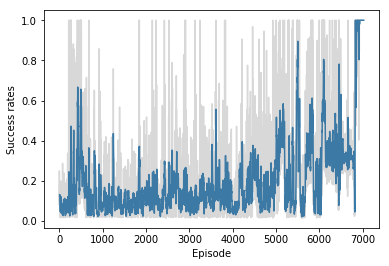

In [164]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

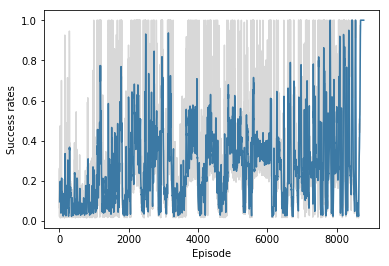

In [159]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

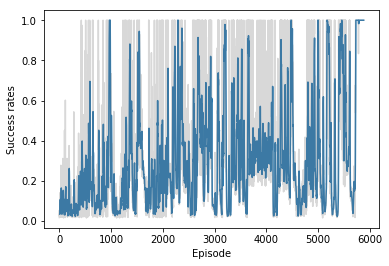

In [156]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

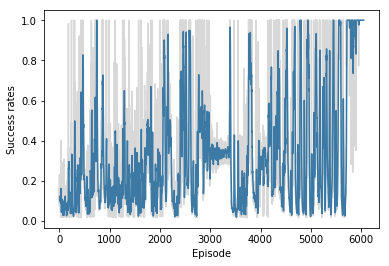

In [147]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

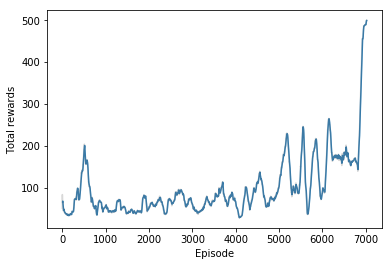

In [165]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

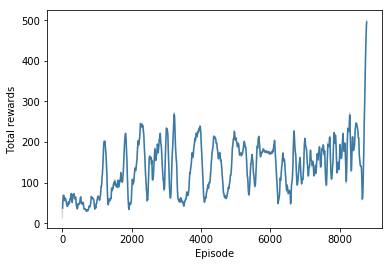

In [161]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

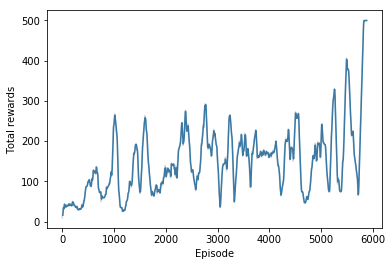

In [157]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

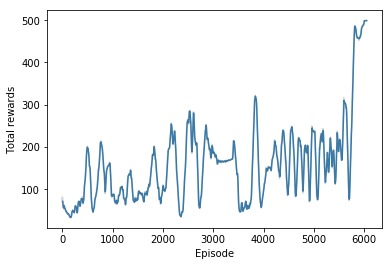

In [154]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Success rates')

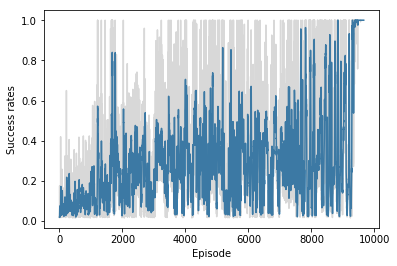

In [134]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

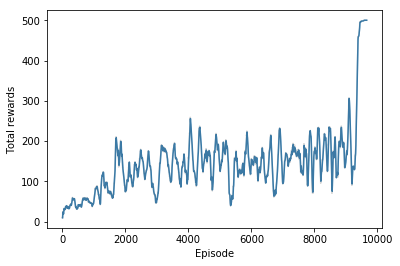

In [126]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Success rates')

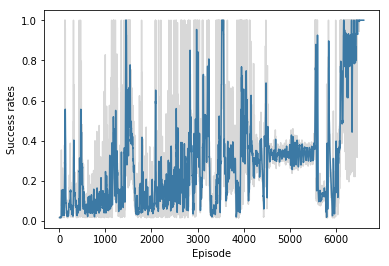

In [104]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

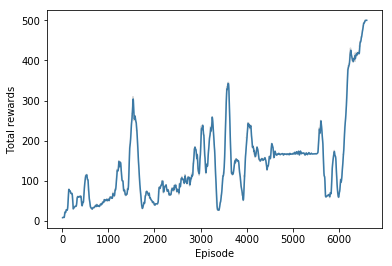

In [102]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

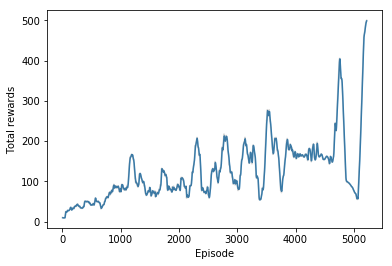

In [82]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

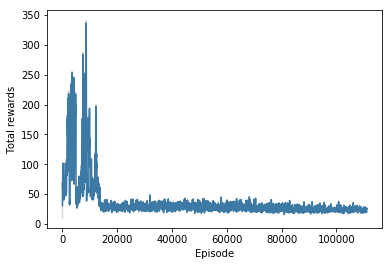

In [67]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

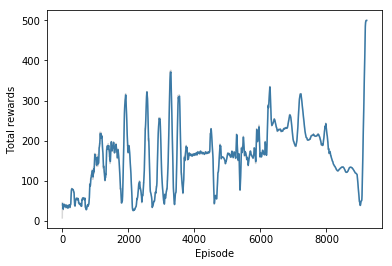

In [52]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

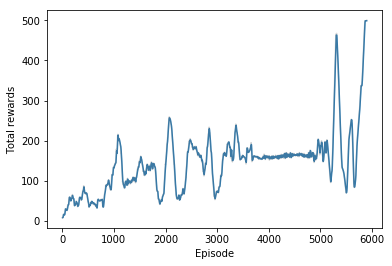

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

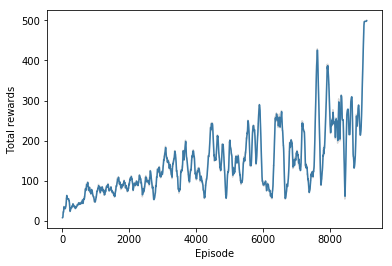

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

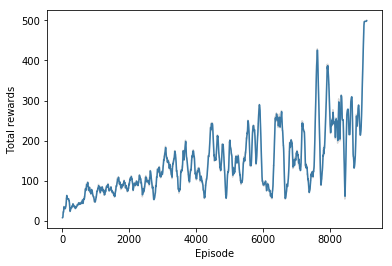

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

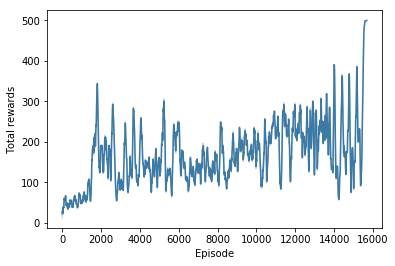

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

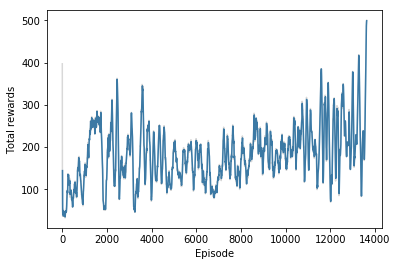

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

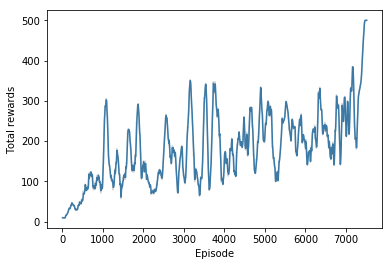

Text(0,0.5,'G losses')

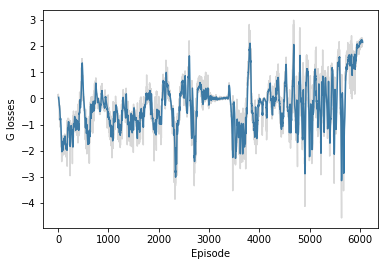

In [149]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

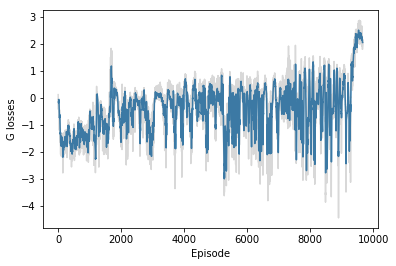

In [130]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

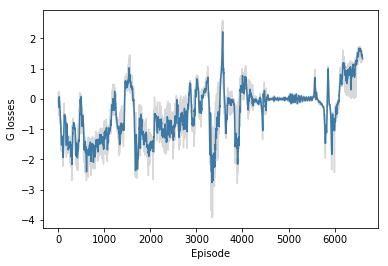

In [105]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

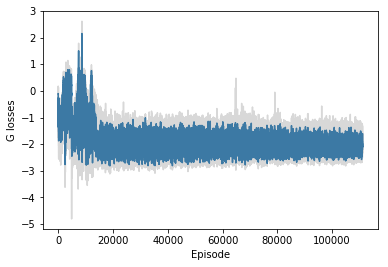

In [68]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

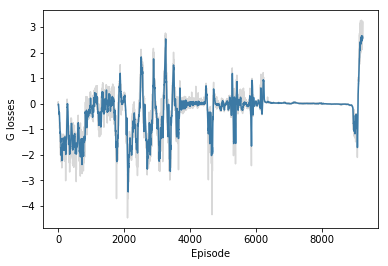

In [53]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

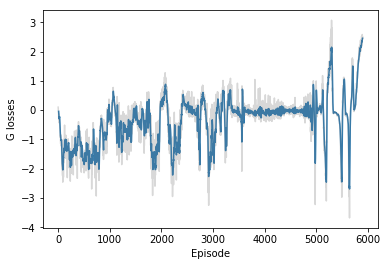

In [29]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

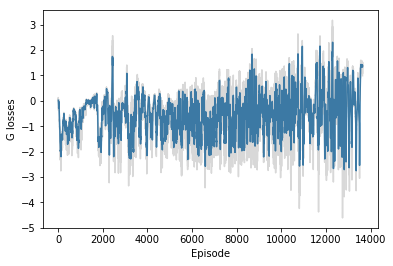

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

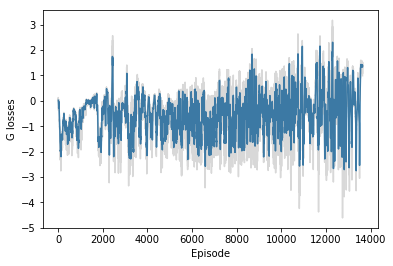

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

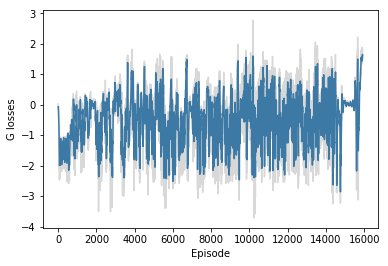
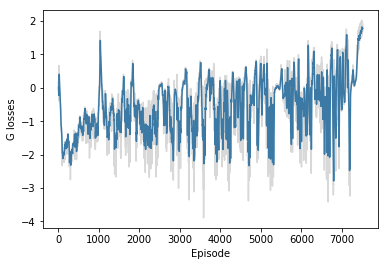

Text(0,0.5,'D losses')

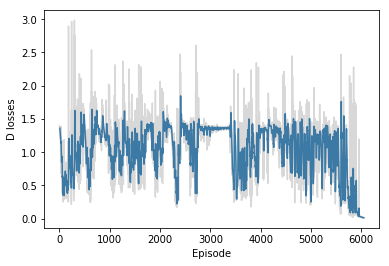

In [150]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

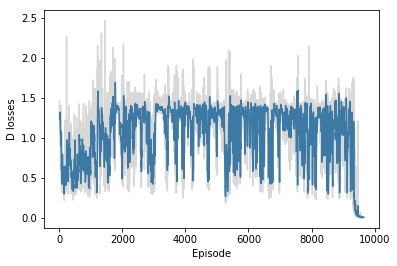

In [131]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

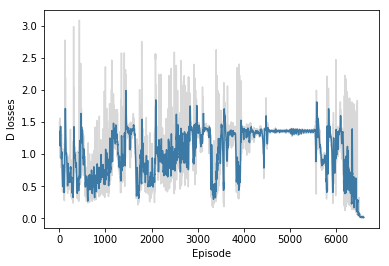

In [106]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

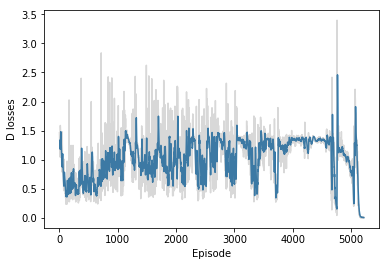

In [83]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

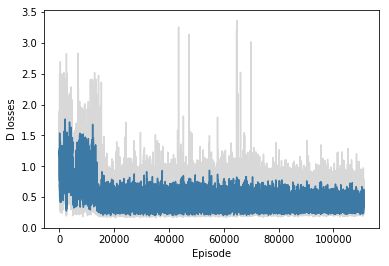

In [69]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

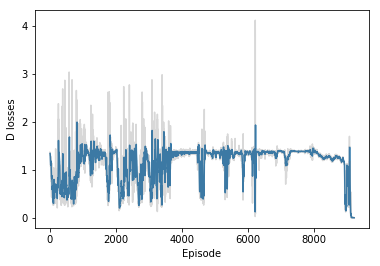

In [54]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

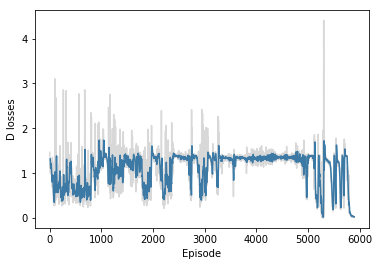

In [30]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

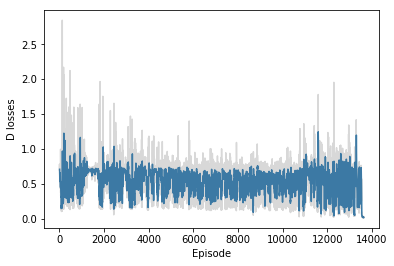

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

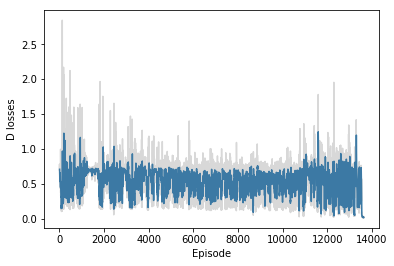

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

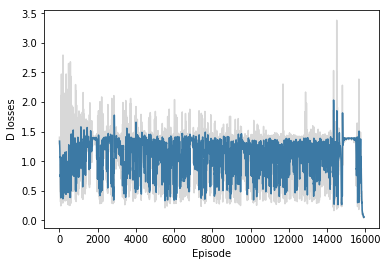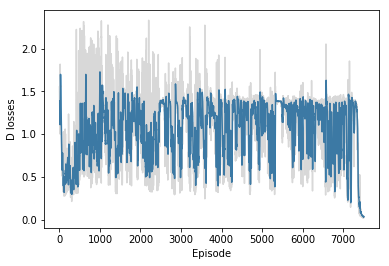

Text(0,0.5,'D losses R')

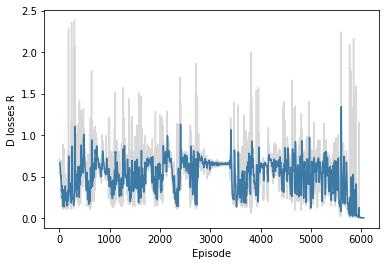

In [152]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

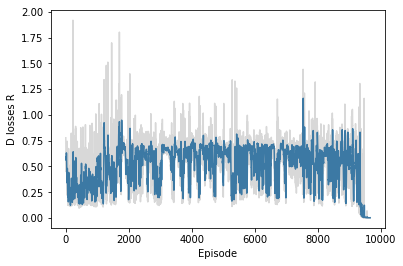

In [132]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

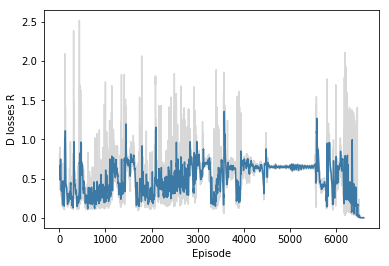

In [107]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

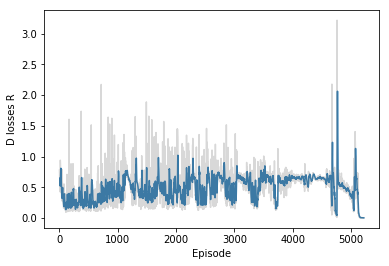

In [84]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

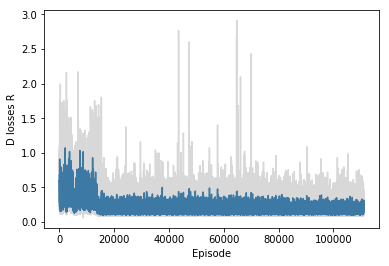

In [70]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

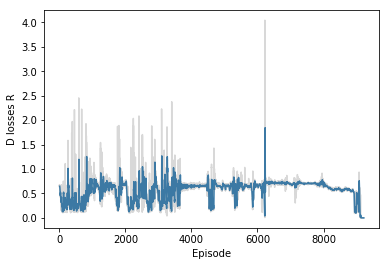

In [55]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

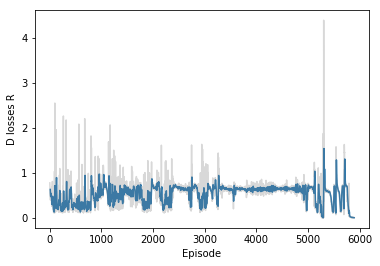

In [31]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

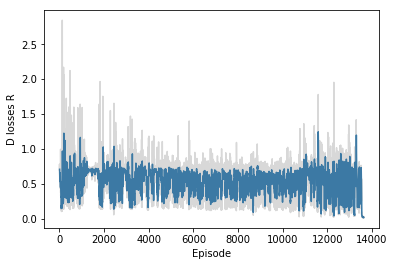

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

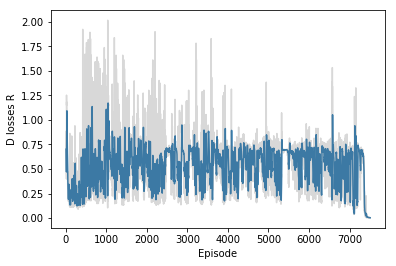

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

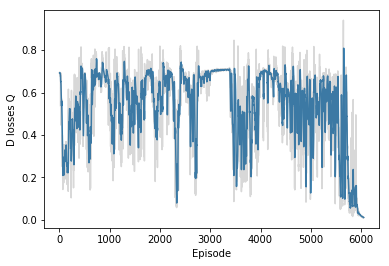

In [153]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

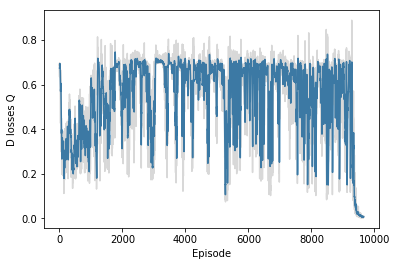

In [133]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

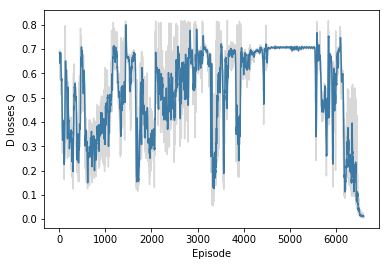

In [108]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

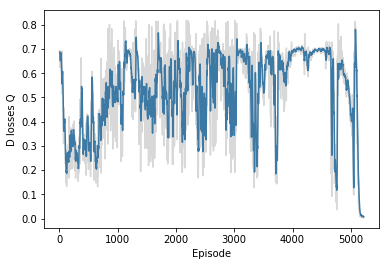

In [85]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

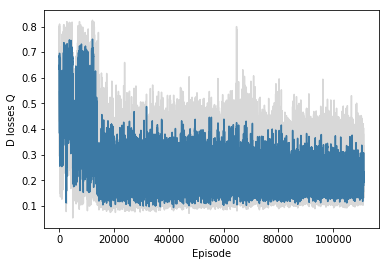

In [71]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

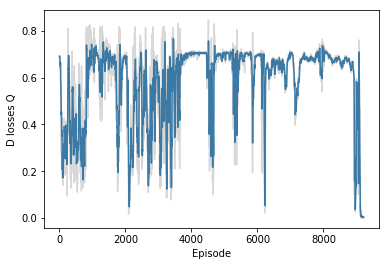

In [56]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

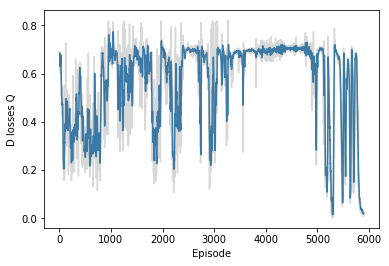

In [32]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

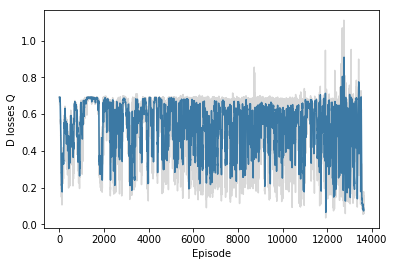

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

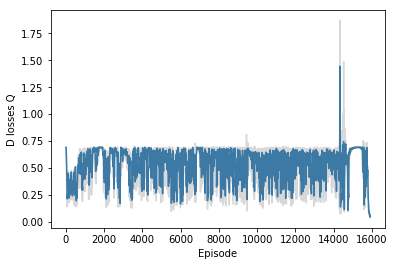

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

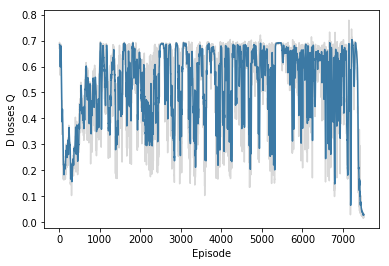

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.